In [308]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Prueba Técnica - Javier Colás

## Datos

1. El fichero **BD_DC.csv** es una base de datos de **100.000 empresas** que realizan su actividad en diferentes 
sectores. En esta base se tienen una serie de variables que contienen **información económica** de las
empresas (facturación, número de empleados, si exporta, si importa o si realiza ambas, si tiene flota de 
vehículos…), su **localización** y algunos **datos de su entorno** (nivel socioeconómico, si está en un polígono, 
habitantes de la zona, etc.). Las veces que “La Empresa E” ha contactado con una empresa se recoge en 
la variable impactos_publicidad.
    * **id**:	*Código de identificación*
    * **tipo_empresa**:	*Personalidad Jurídica o Física (Empresa, Persona y Organismo)*
    * **codpostal**:	*Código Postal*
    * **municipio**:	*Literal de municipio*
    * **provincia**:	*Literal de provincia*
    * **comunidadautonoma**:	*Literal de comunidad autónoma*
    * **capitalpueblo**:	*Clasificación del entorno basada en la cercanía a una capital de provincia*
    * **enpoligono**:	*Clasificación del entorno en función de la situación del negocio en un polígono industrial*
    * **habitantes_municipio**:	*Total población del municipio*
    * **tipo_de_zona**:	*Clasificación del entorno en función de indicadores de diferente naturaleza*
    * **actcnae	Literal**: *CNAE 2009*
    * **mercado	Literal**: *de Mercado Datacentric*
    * **cnae_mercado**:	*Literal de Mercado CNAE*
    * **rangoventas**:	*Clasificación basada en la facturación de la sede del negocio[1, 10]*
    * **rangoempleados**:	*Clasificación basada en los empleados de la sede del negocio [100, -, 5]*
    * **numoficinas**:	*Cantidad de oficinas que tiene un negocio*
    * **tipooficina**:	*Clasificación basasda en el número y la naturaleza de los centros de trabajo/venta/servicio*
    * **anyofundacion**:	*Año de fundación del negocio*
    * **nse**:	*Nivel socioeconómico del entorno del negocio [0, 5]*
    * **tendenciaempleados**:	*Tendencia del número de empelados*
    * **tendenciaingresos**:	*Tendencia de la facturación*
    * **flotaturismos**:	*Negocios con turismos*
    * **flotafurgonetas**:	*Negocios con furgonetas*
    * **flotacamiones**:	*Negocios con camiones*
    * **flotaautobuses**:	*Negocios con autobuses/autocares*
    * **riesgo**:	*Índice de riesgo asociado al negocio*
    * **universo**:	*Clasificación basada en el dinamismo económico de la empresa (activa o inactiva)*
    * **existe_import**:	*Negocios que importan*
    * **existe_export**:	*Negocios que exportan*
    * **existe_importexport**:	*Negocios que importan y exportan*
    * **existe_email**:	*Tenencia de email*
    * **es_ecommerce**:	*Tenencia de ecommerce*
    * **impactos_publicidad**:	*Impactos publicitarios que el cliente ha hecho sobre ese negocio*



2. En el fichero **BD_clientes.csv** se recogen los id de las empresas que son clientes de “La Empresa E”.

## Problema

El negocio de La Empresa E consiste en la venta de productos directamente a empresas, como podría ser 
una compañía que vende material de oficina para despachos, por ejemplo. 

Esta prueba consiste en simular un proyecto desarrollado por DataCentric para La Empresa E. **El objetivo 
es detectar a qué tipo de empresas debe atacar La Empresa E para mejorar sus ventas basándonos en 
datos objetivos de empresas con las que ha contactado (fichero BD_DC.csv) y empresas que se han 
convertido en clientes (BD_clientes.csv) después de ese contacto**.


## Otros objetivos
1. Análisis descriptivo de la información disponible
2. Construir un modelo que detecte la propensión de las empresas de DataCentric a convertirse en 
clientes de la “empresa E”. Podrán utilizarse todas las variables que se consideren.
3. Extraer las empresas más propensas y las conclusiones del análisis.
4. Explicar el método/modelo utilizado y el tratamiento de datos realizado, así como los criterios 
finales en la elección de empresas.


## Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from matplotlib import pyplot
import time

#---------------------------------

## Preprocesando
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import scipy as sc
from scipy.stats import boxcox
from sklearn.base import TransformerMixin

#---------------------------------

## Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics 
from scipy.spatial.distance import cdist 
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as shc

#---------------------------------

## Clasificación
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
import shap



from Funciones_DC import *

# 1. Análisis descriptivo de la información disponible

Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores.

In [3]:
df = pd.read_csv('BD_DC.csv',
                  sep = '\t')
df_clientes_E = pd.read_csv('BD_clientes.csv',
                  sep = '\t')

## 1.1 Número de observaciones y valores ausentes

In [4]:
pd.set_option('display.max_columns', None)
print ("nº Filas: %d\tnº Columnas: %d\n" % (df.shape[0], df.shape[1]))
print ("Columnas:\t", np.array(df.columns))
df.head()

nº Filas: 100000	nº Columnas: 33

Columnas:	 ['id' 'tipo_empresa' 'codpostal' 'municipio' 'provincia'
 'comunidadautonoma' 'capitalpueblo' 'enpoligono' 'habitantes_municipio'
 'tipo_de_zona' 'actcnae' 'mercado' 'cnae_mercado' 'rangoventas'
 'rangoempleados' 'numoficinas' 'tipooficina' 'anyofundacion' 'nse'
 'tendenciaempleados' 'tendenciaingresos' 'flotaturismos'
 'flotafurgonetas' 'flotacamiones' 'flotaautobuses' 'riesgo' 'universo'
 'existe_import' 'existe_export' 'existe_importexport' 'existe_email'
 'es_ecommerce' 'impactos_publicidad']


,id,tipo_empresa,codpostal,municipio,provincia,comunidadautonoma,capitalpueblo,enpoligono,habitantes_municipio,tipo_de_zona,actcnae,mercado,cnae_mercado,rangoventas,rangoempleados,numoficinas,tipooficina,anyofundacion,nse,tendenciaempleados,tendenciaingresos,flotaturismos,flotafurgonetas,flotacamiones,flotaautobuses,riesgo,universo,existe_import,existe_export,existe_importexport,existe_email,es_ecommerce,impactos_publicidad
0,1,E,46008,VALENCIA,VALENCIA,COMUNITAT VALENCIANA,CAPITAL,0,786189,7,PINTURA Y ACRISTALAMIENTO,CONSTRUCCION Y OBRAS PUBLICAS,CONSTRUCCION,7.0,125.0,NaN,SEDE,31/07/1989,4,POSITIVA LINEAL,POSITIVA NO LINEAL,0,0,0,0,NaN,ACTIVEBUSINESS,0,0,0,1,0,3
1,2,E,28049,MADRID,MADRID,MADRID,CAPITAL,0,3141991,7,OTROS SERVICIOS RELACIONADOS CON LAS TECNOLOGÍ...,TELECOMUNICACIONES,INFORMACION Y COMUNICACIONES,1.0,NaN,NaN,SEDE,22/05/2012,3,NaN,NaN,0,0,0,0,NaN,MARKETBASE,0,0,0,1,0,2
2,3,E,8172,SANT CUGAT DEL VALLÈS,BARCELONA,CATALUNYA,PUEBLO,0,87830,5,PELUQUERÍA Y OTROS TRATAMIENTOS DE BELLEZA,COSMETICA Y CUIDADO PERSONAL,OTROS SERVICIOS,7.0,135.0,NaN,SEDE,01/01/1999,5,POSITIVA LINEAL,POSITIVA LINEAL,0,0,0,0,NaN,ACTIVEBUSINESS,0,0,0,1,0,3
3,4,E,8011,BARCELONA,BARCELONA,CATALUNYA,CAPITAL,0,1604555,7,COMERCIO AL POR MAYOR DE TEXTILES,TEXTIL Y CONFECCION,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,6.0,100.0,NaN,SEDE,30/01/2015,5,NaN,NaN,0,0,0,0,NaN,ACTIVEBUSINESS,0,0,0,0,0,1
4,5,E,28031,MADRID,MADRID,MADRID,CAPITAL,1,3141991,7,OTRAS ACTIVIDADES DE IMPRESIÓN Y ARTES GRÁFICAS,ARTES GRAFICAS,INDUSTRIA MANUFACTURERA,4.0,120.0,NaN,SEDE,27/09/2013,0,POSITIVA NO LINEAL,POSITIVA LINEAL,0,0,0,0,NaN,ACTIVEBUSINESS,0,0,0,0,0,5


Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores ausentes son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas. Aunque la imputación de valores ausentes es parte del preprocesado y, por lo tanto, debe de aprenderse únicamente con los datos de entrenamiento, su identificación se tiene que realizar antes de separar los datos para asegurar que se establecen todas las estrategias de imputación necesarias. 

Además, este problema es una excepción de esta norma, ya que contamos con una base de datos propios y no vamos a tener nuevas entradas de empresas (potenciales clientes) nunca vistas. Por lo que la imputación de valores se hará con los datos de entrenamiento, validación y test.

Creamos una nueva variable **'Target'**, toma un valor de 1 si la empresa i es cliente de la 'Empresa E' , 0 si la empresa i ha recibido impactos publicitarios y no es cliente, y 'NaN' si no ha recibido impactos y no es cliente.

In [5]:
df = target_creation(df_clientes_E, df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tipo_empresa          100000 non-null  object 
 1   codpostal             100000 non-null  int64  
 2   municipio             100000 non-null  object 
 3   provincia             100000 non-null  object 
 4   comunidadautonoma     100000 non-null  object 
 5   capitalpueblo         100000 non-null  object 
 6   enpoligono            100000 non-null  int64  
 7   habitantes_municipio  100000 non-null  int64  
 8   tipo_de_zona          100000 non-null  int64  
 9   actcnae               99990 non-null   object 
 10  mercado               99990 non-null   object 
 11  cnae_mercado          100000 non-null  object 
 12  rangoventas           99999 non-null   float64
 13  rangoempleados        95996 non-null   float64
 14  numoficinas           95946 non-null   float64
 15  

Las variables que tienen el **tipo correcto** son:

* habitantes_municipio
* impactos_publicidad

El resto de variables **cambian su tipo a categóricas**, con la **excepción** de:

* codpostal: **string**
* numoficinas: **int**
* anyofundacion: **string**

Además, fijamos como índice la variable ID. Y creamos una nueva variable llamada **'dias_creacion'**, que es la antiguedad en días desde la fecha de hoy hasta la fecha de su creación. Con el objetivo de poder utilizar la variable **'anyofundacion'** en neustros modelos.


In [7]:
# Modificamos el tipo de dato de las columnas.
df = df.astype({'codpostal': 'string', 'numoficinas': 'int', 'anyofundacion': 'string'}, errors='ignore')

columnas_sin_cambios = ['codpostal', 'habitantes_municipio', 'numoficinas', 'anyofundacion', 'impactos_publicidad', 'Target']

# Trasformamos el resto de columnas a tipo categórico.
to_category(df, columnas_sin_cambios)

# Convertimos la fecha de antiguedad, en años de antiguedad desde el año de hoy. Eliminamos la columna anyofundacion.
df['dias_creacion'] = df.anyofundacion.apply(año_antiguedad_to_dias_antiguedad)
df.drop('anyofundacion', axis = 1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   tipo_empresa          100000 non-null  category
 1   codpostal             100000 non-null  string  
 2   municipio             100000 non-null  category
 3   provincia             100000 non-null  category
 4   comunidadautonoma     100000 non-null  category
 5   capitalpueblo         100000 non-null  category
 6   enpoligono            100000 non-null  category
 7   habitantes_municipio  100000 non-null  int64   
 8   tipo_de_zona          100000 non-null  category
 9   actcnae               99990 non-null   category
 10  mercado               99990 non-null   category
 11  cnae_mercado          100000 non-null  category
 12  rangoventas           99999 non-null   category
 13  rangoempleados        95996 non-null   category
 14  numoficinas           95946 non-null

**Con la inclusión de la variable Target las dimension del DataSet son de 100.000 Filas y 33 Columnas.**


In [9]:
print ("nº Filas: %d\tnº Columnas: %d\n" % (df.shape[0], df.shape[1]))

nº Filas: 100000	nº Columnas: 33



Número de Clientes 5278
Número de Clientes Fallidos 56881
Número de Clientes Potenciales 37841


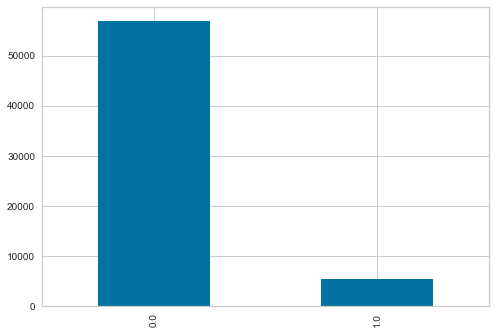

In [10]:
df['Target'].value_counts().plot(kind='bar')

print(f'Número de Clientes {sum(df.Target == 1)}')
print(f'Número de Clientes Fallidos {sum(df.Target == 0)}')
print(f'Número de Clientes Potenciales {sum(df.Target.isna())}')

**La variable Target se distribuye de la siguiente forma:**
* **Número de Clientes**: 5.278
* **Número de Clientes Fallidos** : 56.881
* **Número de Clientes Potenciales**: 37.841

Vamos a ver cuantas clases tienen las variables categóricas. La mayoría son variables binarias. Luego estás las que tienen un número muy elevado de categorías, como la variable 'municipio', 'rangoempleados', 'actcnae' y 'mercado'.

In [11]:
# Veamos ahora cuántos valores diferentes tienen las columnas categóricas. ¿Qué observamos?
numero_categorias(df.drop('Target', axis = 1))

tipo_empresa 2
municipio 3992
provincia 51
comunidadautonoma 18
capitalpueblo 2
enpoligono 2
tipo_de_zona 7
actcnae 563
mercado 53
cnae_mercado 21
rangoventas 11
rangoempleados 4028
tipooficina 3
nse 6
tendenciaempleados 5
tendenciaingresos 5
flotaturismos 2
flotafurgonetas 2
flotacamiones 2
flotaautobuses 2
riesgo 6
universo 3
existe_import 2
existe_export 2
existe_importexport 2
existe_email 2
es_ecommerce 2


**Valores Nulos**

riesgo                  99372
tendenciaingresos       62117
tendenciaempleados      53813
Target                  37841
dias_creacion            9004
numoficinas              4054
rangoempleados           4004
universo                   13
actcnae                    10
mercado                    10
rangoventas                 1
flotafurgonetas             0
existe_import               0
existe_export               0
existe_importexport         0
existe_email                0
flotaautobuses              0
es_ecommerce                0
impactos_publicidad         0
flotacamiones               0
tipo_empresa                0
flotaturismos               0
codpostal                   0
tipooficina                 0
cnae_mercado                0
tipo_de_zona                0
habitantes_municipio        0
enpoligono                  0
capitalpueblo               0
comunidadautonoma           0
provincia                   0
municipio                   0
nse                         0
dtype: int

<AxesSubplot:>

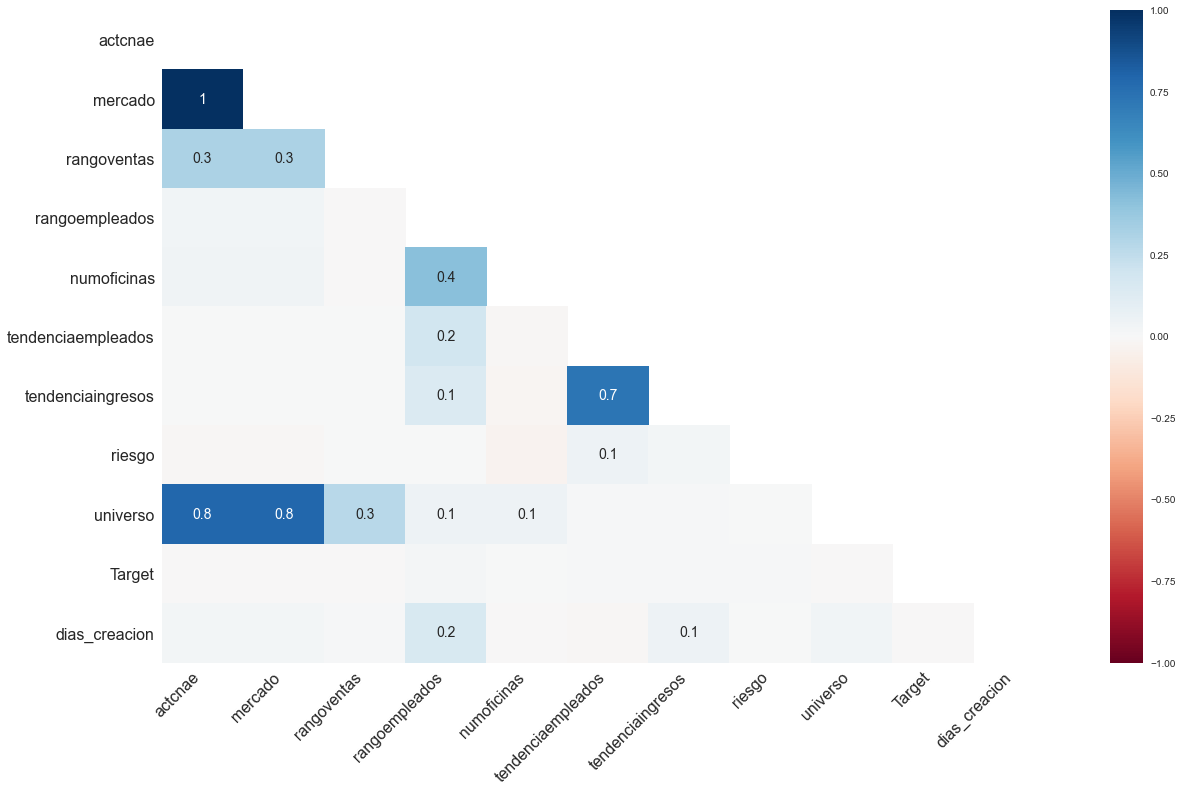

In [12]:
# Miremos a ver cómo andamos de NaNs
numero_nulos(df)
msno.heatmap(df)

Miramos como se distribuyen los valores ausentes de nuestro DataSet y cual es la relación de los valores nulos de cada campo frente a los restantes. Es una forma de ver como de parecidas son las variables, o si una variable se puede deducir de otra, como es el caso de 'mercado' y 'actcnae'.

Otras relaciones son:

* Correlación alta entre **'mercado' y 'universo'** y **'actcnae' y 'universo'**.

* Correlación alta entre **'tendenciaingresos'** y **'tendenciaempleados'**. Aunque esta realción es debida por la gran cantidad de valores nulos que tienen los campos.


Vamos a **eliminar** los campos que tengan más del **30% de los campos nulos**, es decir:

* 'riesgo'
* 'tendenciaingresos'
* 'tendenciaempleados'

También eliminamos el campo **'existe_importexport'** ya que se puede deducir de las variables **'existe_import'** y **'existe_export'**. Si ambas son 1, la variable 'existe_importexport' será 1, y si alguna de las dos es 0 será 0 también.

Ocurre los mismo con el **código postal**, tenemos la misma información en los campos de CCAA y municipio.

In [13]:
# De las columnas 'mercado', 'actcnae', 'cnae_mercado', vamos a seleccionar 'cnae_mercado' y a eliminar las otras dos. Porque
# da una visión más agregada del sector al que pertenece, y evitamos posibles problemas de sobreinformación. Es decir, varias 
# variables que aportan la misma información.

#df.drop(['actcnae', 'mercado'], axis = 1, inplace=True)

#Lo mismo pasa para la varaible existe_importexport, se puede obtener de la suma de existe_import y existe_export.

df.drop(['existe_importexport', 'codpostal', 'riesgo', 'tendenciaempleados', 'tendenciaingresos', 'actcnae'],
        axis = 1,
        inplace=True)


# Podemos pensar hacer lo mismo para la CCAA, Provincia, Municipio y Codigo postal. Hcer encoding con vectores o algo así. Y ver
# la correlación entre ellas, y la target. Justificacion de porq quitarlas.

Si alguno de los niveles de una **variable cualitativa tiene muy pocas observaciones** en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. En estos casos, suele ser conveniente:

* Eliminar las observaciones del grupo minoritario si es una variable multiclase.

* Eliminar la variable si solo tiene dos niveles.

* Agrupar los niveles minoritarios en un único grupo.

* Asegurar que, en la creación de las particiones, todos los grupos estén representados en cada una de ellas.



Vamos a ver como se distribuyen las clases de las variables categóricas. Vamos a representar con un histograma para cada campo la distribución de frecuencias de cada clase. Además, vamos a crear una tabla de contingencia para cada variable categórica y ver si hay clases que son más influyentes en el Target.

# 1.3 Análisis Descriptivo

In [14]:
variables_catplot = df.select_dtypes(include = 'category')

# Columnas con menos de 20 categorias
features_catplot = []
for i in variables_catplot:
    if len(set(df[i])) < 20:
        features_catplot.append(i)
    else:
        pass

Modificaciones:

* **tipo_empresa**, eliminamos este campo porque tiene muy pocas observaciones de la clase 'O'. Además, que la empresa pertenezca a la clase 'O' no es determinante para predecir el Target.
* **comunidad_autonoma**, vamos a agrupar las CCAA de Ceuta, Canarias y Balears en un nuevo grupo llamado 'otro', por el reducido tamaño de la muestra y que estas variables sean más robustas en nuestro futuro modelo.
* **rangoventas**, juntamos las 3 categrías más altas (8, 9 y 10) en la categoría 8.
* **tipooficina**, hay una clase, 'SUCURSAL', muy minoritaria. Pero vemos que esta nos ayuda a separar muy bien la clase postiva y negativa del Target. Por eso no vamos a modificarla.
* **nse**, juntamos la clase 1 y 2.
* **flotaautobuses**, eliminamos este campo porque tiene muy pocas observaciones de la clase '1'. Además, que la empresa pertenezca a la clase '1' es poco determinante para predecir el Target.
* **existe_import** y **existe_export**, tienen pocas observaciones de la clase positiva, pero estas nos ayudan a discriminar entre el Target postivo o Negativo. No lo eliminamos.
* **es_ecommerce**, eliminamos este campo porque tiene muy pocas observaciones de la clase '1'. Además, que la empresa pertenezca a la clase '1' no es determinante para predecir el Target.

Observaciones no nulas, columna tipo_empresa : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   E   |   99688    |     5276     |      5.29 %       |    56877     |      57.05 %      |
|   O   |    312     |      2       |      0.64 %       |      4       |      1.28 %       |
+-------+------------+--------------+-------------------+--------------+-------------------+


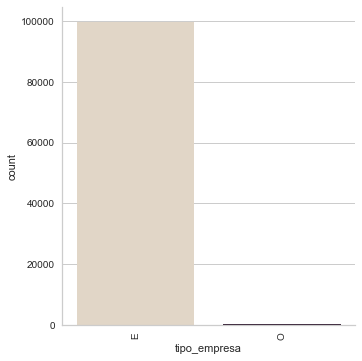

Observaciones no nulas, columna comunidadautonoma : 100000 

+----------------------+------------+--------------+-------------------+--------------+-------------------+
|        Clase         | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+----------------------+------------+--------------+-------------------+--------------+-------------------+
|      CATALUNYA       |   27236    |     2053     |      7.54 %       |    15188     |      55.76 %      |
|        MADRID        |   21196    |     1050     |      4.95 %       |    12702     |      59.92 %      |
|      ANDALUCIA       |   13273    |     464      |       3.5 %       |     7480     |      56.35 %      |
| COMUNITAT VALENCIANA |   10872    |     495      |      4.55 %       |     6070     |      55.83 %      |
|      PAIS VASCO      |    4917    |     281      |      5.71 %       |     2773     |      56.38 %      |
|   CASTILLA Y LEON    |    4347    |     149      |      3.43 %       |   

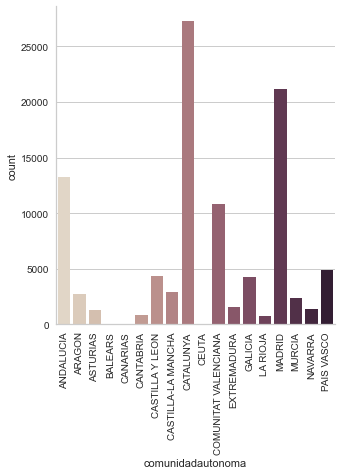

Observaciones no nulas, columna capitalpueblo : 100000 

+---------+------------+--------------+-------------------+--------------+-------------------+
|  Clase  | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+---------+------------+--------------+-------------------+--------------+-------------------+
| PUEBLO  |   58398    |     3200     |      5.48 %       |    32294     |      55.3 %       |
| CAPITAL |   41602    |     2078     |      4.99 %       |    24587     |      59.1 %       |
+---------+------------+--------------+-------------------+--------------+-------------------+


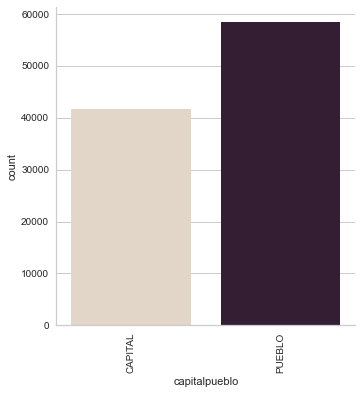

Observaciones no nulas, columna enpoligono : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   82923    |     3944     |      4.76 %       |    47300     |      57.04 %      |
|   1   |   17077    |     1334     |      7.81 %       |     9581     |      56.1 %       |
+-------+------------+--------------+-------------------+--------------+-------------------+


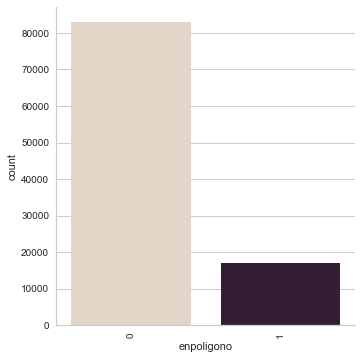

Observaciones no nulas, columna tipo_de_zona : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   7   |   27950    |     1516     |      5.42 %       |    16618     |      59.45 %      |
|   6   |   20314    |     967      |      4.76 %       |    11583     |      57.02 %      |
|   1   |   14142    |     833      |      5.89 %       |     7859     |      55.57 %      |
|   4   |   11842    |     599      |      5.06 %       |     6483     |      54.74 %      |
|   5   |   10766    |     567      |      5.27 %       |     6055     |      56.24 %      |
|   3   |    8194    |     442      |      5.39 %       |     4506     |      54.98 %      |
|   2   |    6792    |     354      |      5.21 %       |     3777     |      55.6 %       |
+-------+-----

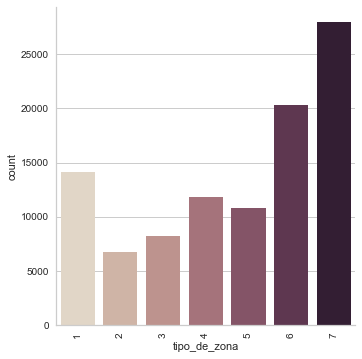

Observaciones no nulas, columna rangoventas : 99999 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|  1.0  |   27728    |     756      |      2.73 %       |    22173     |      79.96 %      |
|  2.0  |   18417    |     547      |      2.97 %       |    11155     |      60.57 %      |
|  3.0  |   16154    |     722      |      4.47 %       |     6537     |      40.46 %      |
|  5.0  |   10818    |     798      |      7.38 %       |     3711     |      34.3 %       |
|  4.0  |    9622    |     649      |      6.74 %       |     4808     |      49.96 %      |
|  6.0  |    8014    |     660      |      8.23 %       |     4406     |      54.97 %      |
|  7.0  |    6308    |     666      |      10.56 %      |     2569     |      40.72 %      |
|  8.0  |    235

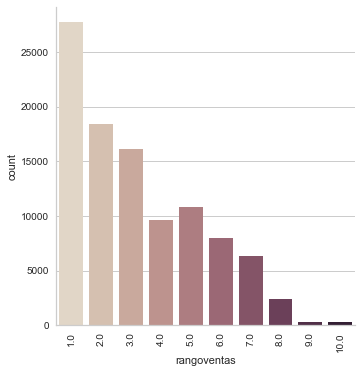

Observaciones no nulas, columna tipooficina : 100000 

+----------+------------+--------------+-------------------+--------------+-------------------+
|  Clase   | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+----------+------------+--------------+-------------------+--------------+-------------------+
|  UNICA   |   90736    |     4739     |      5.22 %       |    51842     |      57.13 %      |
|   SEDE   |    9091    |     525      |      5.77 %       |     4902     |      53.92 %      |
| SUCURSAL |    173     |      14      |      8.05 %       |     137      |      78.74 %      |
+----------+------------+--------------+-------------------+--------------+-------------------+


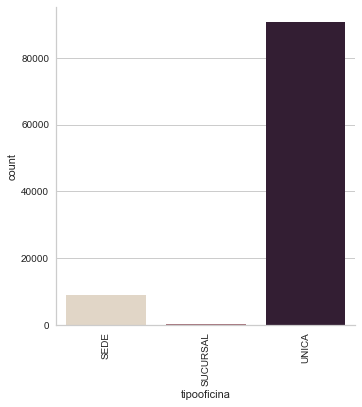

Observaciones no nulas, columna nse : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   3   |   26049    |     1256     |      4.82 %       |    14263     |      54.75 %      |
|   0   |   25575    |     1494     |      5.84 %       |    14489     |      56.65 %      |
|   4   |   20814    |     1113     |      5.35 %       |    11887     |      57.11 %      |
|   5   |   18190    |     1055     |       5.8 %       |    11050     |      60.74 %      |
|   2   |    6876    |     291      |      4.23 %       |     3786     |      55.05 %      |
|   1   |    2496    |      69      |      2.76 %       |     1406     |      56.31 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


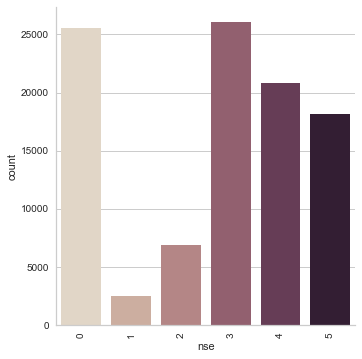

Observaciones no nulas, columna flotaturismos : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   91537    |     4615     |      5.04 %       |    52295     |      57.13 %      |
|   1   |    8463    |     663      |      7.83 %       |     4586     |      54.18 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


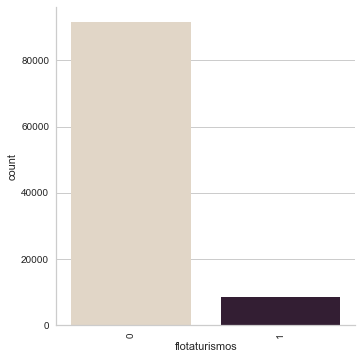

Observaciones no nulas, columna flotafurgonetas : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   94327    |     4679     |      4.96 %       |    53801     |      57.04 %      |
|   1   |    5673    |     599      |      10.56 %      |     3080     |      54.28 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


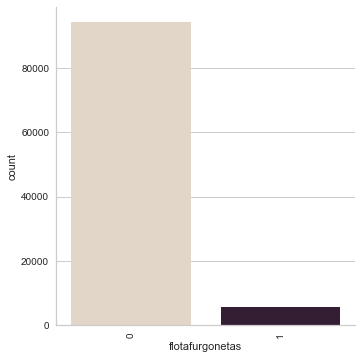

Observaciones no nulas, columna flotacamiones : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   98242    |     5135     |      5.23 %       |    55893     |      56.89 %      |
|   1   |    1758    |     143      |      8.13 %       |     988      |      56.17 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


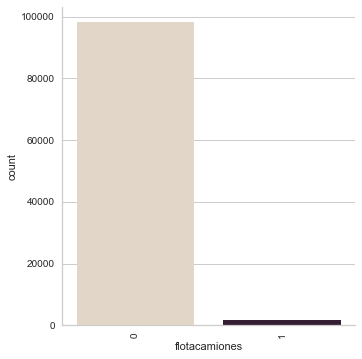

Observaciones no nulas, columna flotaautobuses : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   99951    |     5274     |      5.28 %       |    56838     |      56.87 %      |
|   1   |     49     |      4       |       8.0 %       |      43      |      86.0 %       |
+-------+------------+--------------+-------------------+--------------+-------------------+


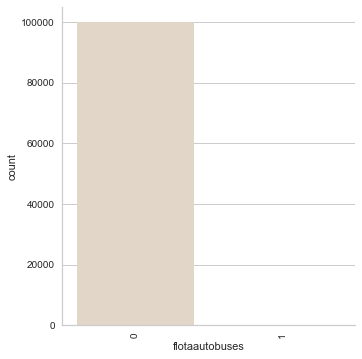

Observaciones no nulas, columna universo : 99987 

Observaciones no nulas, columna existe_import : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   98217    |     4955     |      5.04 %       |    56027     |      57.04 %      |
|   1   |    1783    |     323      |      18.11 %      |     854      |      47.87 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


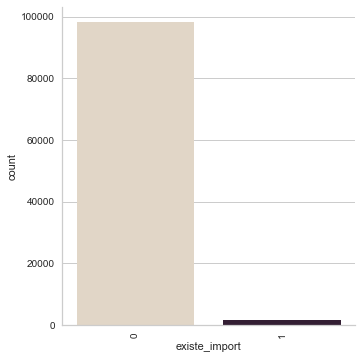

Observaciones no nulas, columna existe_export : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   96144    |     4717     |      4.91 %       |    54874     |      57.07 %      |
|   1   |    3856    |     561      |      14.54 %      |     2007     |      52.04 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


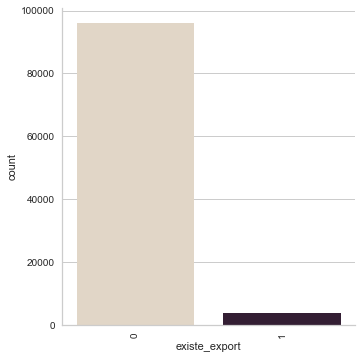

Observaciones no nulas, columna existe_email : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   74983    |     3297     |       4.4 %       |    42663     |      56.9 %       |
|   1   |   25017    |     1981     |      7.92 %       |    14218     |      56.83 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


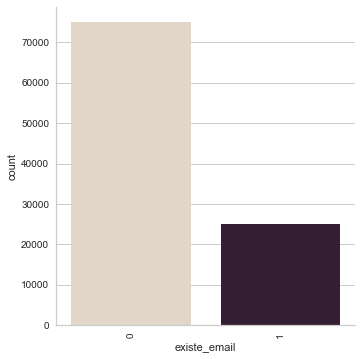

Observaciones no nulas, columna es_ecommerce : 100000 

+-------+------------+--------------+-------------------+--------------+-------------------+
| Clase | Frecuencia | F.C Positiva | % Target Positiva | F.C Negativa | % Target Negativo |
+-------+------------+--------------+-------------------+--------------+-------------------+
|   0   |   99058    |     5225     |      5.27 %       |    56350     |      56.89 %      |
|   1   |    942     |      53      |      5.62 %       |     531      |      56.31 %      |
+-------+------------+--------------+-------------------+--------------+-------------------+


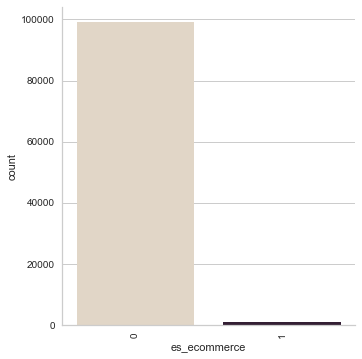

In [15]:
descriptivo_categoricas(df, features_catplot)

In [16]:
df.rangoventas = df.rangoventas.apply(juntar_rangoventas).astype("category")
df.comunidadautonoma = df.comunidadautonoma.apply(juntar_CCAA)
df.nse = df.nse.apply(juntar_nse).astype("category")

In [17]:
# Eliminamos más campos
df.drop(['tipo_empresa', 'flotaautobuses', 'es_ecommerce'], axis = 1, inplace=True)

La distribución de los valores de las variables predictoras puede tener una importancia crucial en el resultado de nuestro algoritmo de aprendizaje. El problema principal con las variables numéricas no es su escala sino el **sesgo** que tiene. Se puede arreglar con la transformación de **BoxCox** (yeo-johnson para valores negativos y positivos).

En la última versión de sklearn está implementada esta transformación en el transformer **PowerTransformer**, con el objetivo deque los datos sean más gaussianos y eliminemos los sesgos.

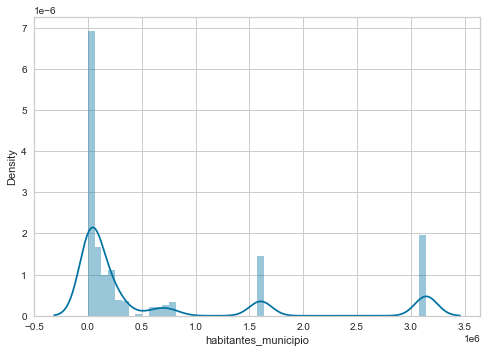

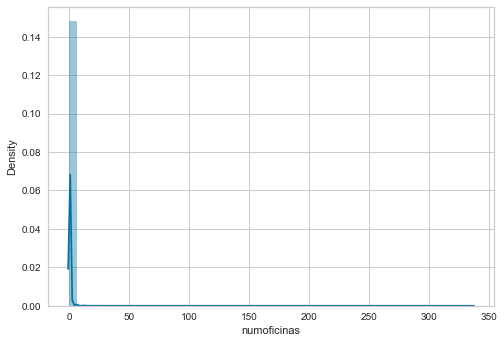

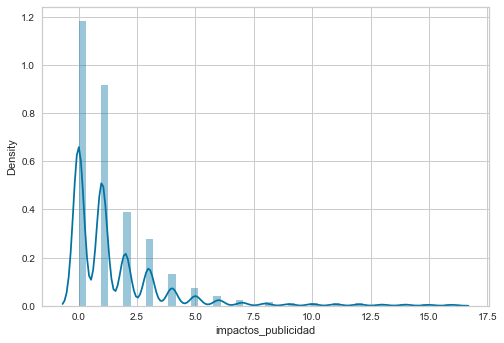

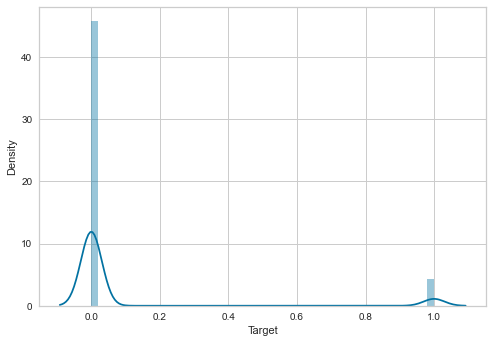

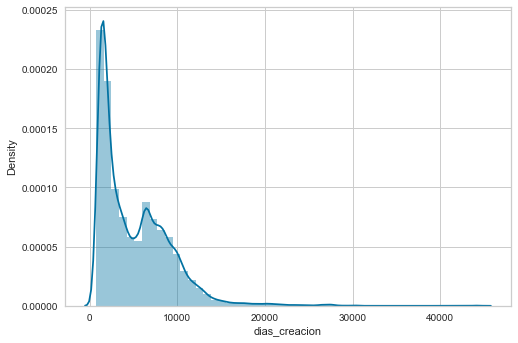

In [18]:
for i in list(df.select_dtypes(['number']).columns):
    sns.distplot(df[i])
    plt.show()

Las clases **ColumnTransformer** y **make_column_transformer** del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. Aunque en este ejercicio obviaremos esta afirmación, ya que el data leakage no nos afecta, el dataset de las 100.000 empresas es siempre fijo y conocido.


En nuestro caso hemos hecho **4 particiones**, segun el tipo de dato:

* **Numéricas**, imputamos los valores nulos con la media, eliminamos el sesgo con la trasformación yeo-johnson, y escalamos los datos para que todos los predictores estén aproximadamente en la misma escala. Utilizamos la estandarización max-min (MinMaxScaler), es decir, transformar los datos de forma que estén dentro del rango [0, 1].

* **Binarias**, imputamos los valores nulos con la clase más frecuente y dummificamos las variables. No hace falta escalar estas varibles porque ya se encuentran entre 0 y 1.

* **No Binarias**, imputamos los valores nulos con la clase más frecuente. Para categroizar caracterísiticas con muliples clases utilizamos Target Encoder,las variables seleccionadas se sustituyen por una mezcla de la probabilidad posterior del Target, dado el valor categórico particular y la probabilidad previa del objetivo sobre todos los datos de entrenamiento. Una vez hecha la trasformación, utilizamos la estandarización max-min (MinMaxScaler), es decir, transformar los datos de forma que estén dentro del rango [0, 1].

* **Ordinales**, siguen el mismo proceso que las Binarias, a excepción que se le aplica un Encoder ordinal.

<img src="colum trasformer.PNG">

In [20]:
# Definimos los predictores
predictores_num = columnas_numericas(df)
predictores_dummy = columnas_binarias(df)
predictores_impact = columnas_no_binarias(df)
predictores_ordinarios = ['tipo_de_zona','rangoventas', 'nse']


# Definimos los vectores de predictores y la respuesta
y = df['Target']
X = df[predictores_num + predictores_dummy + predictores_impact + predictores_ordinarios]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('BoxCox',  PowerTransformer(method='yeo-johnson')),
    ('MinMaxScaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder( drop = 'first'))])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('ordinal', OrdinalEncoder()),
    ('MinMaxScaler', MinMaxScaler())])

impact_transformer = Pipeline(steps=[
    ('impact_coding', ce.TargetEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('MinMaxScaler', MinMaxScaler())])

preprocesado = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, predictores_num),
        ('cat', categorical_transformer, predictores_dummy),
        ('imp', impact_transformer, predictores_impact),
        ('ord', ordinal_transformer, predictores_ordinarios)])

# Definimos la tubería


steps = [('feat_prepro', preprocesado)]

pipe = Pipeline(steps)

pipe.fit(X, y)


Pipeline(steps=[('feat_prepro',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('BoxCox',
                                                                   PowerTransformer()),
                                                                  ('MinMaxScaler',
                                                                   MinMaxScaler())]),
                                                  ['habitantes_municipio',
                                                   'numoficinas',
                                                   'impactos_publicidad',
                                                   'dias_creacion']),
                                                 ('cat',
                                                  Pipel

In [21]:
clientes = df[predictores_num + predictores_dummy + predictores_impact + predictores_ordinarios][df.Target == 1]
clientes_potenciales = df[predictores_num + predictores_dummy + predictores_impact + predictores_ordinarios][df.Target != 1]

In [22]:
clientes = pd.DataFrame(pipe.transform(clientes))
clientes_potenciales = pd.DataFrame(pipe.transform(clientes_potenciales))
df_entero = pd.DataFrame(pipe.transform(X))

In [23]:
clientes.columns = predictores_num + predictores_dummy + predictores_impact + predictores_ordinarios
clientes_potenciales.columns = predictores_num + predictores_dummy + predictores_impact + predictores_ordinarios
df_entero.columns = predictores_num + predictores_dummy + predictores_impact + predictores_ordinarios

In [24]:
df_entero.select_dtypes(['number']).describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
habitantes_municipio,100000.0,0.66,0.22,0.0,0.50,0.64,0.84,1.0
numoficinas,100000.0,0.05,0.22,0.0,0.00,0.00,0.00,1.0
impactos_publicidad,100000.0,0.34,0.30,0.0,0.00,0.40,0.57,1.0
dias_creacion,100000.0,0.39,0.19,0.0,0.22,0.39,0.54,1.0
capitalpueblo,100000.0,0.58,0.49,0.0,0.00,1.00,1.00,1.0
enpoligono,100000.0,0.17,0.38,0.0,0.00,0.00,0.00,1.0
flotaturismos,100000.0,0.08,0.28,0.0,0.00,0.00,0.00,1.0
flotafurgonetas,100000.0,0.06,0.23,0.0,0.00,0.00,0.00,1.0
flotacamiones,100000.0,0.02,0.13,0.0,0.00,0.00,0.00,1.0
universo,100000.0,0.53,0.50,0.0,0.00,1.00,1.00,1.0


No se deben incluir en el modelo predictores que contengan un único valor (cero-varianza) ya que no aportan información. Tampoco es conveniente incluir predictores que tengan una varianza próxima a cero, es decir, predictores que toman solo unos pocos valores, de los cuales, algunos aparecen con muy poca frecuencia. El problema con estos últimos es que pueden convertirse en predictores con varianza cero cuando se dividen las observaciones por validación cruzada o bootstrap.

**No eliminamos ninguna variable más.**

In [25]:
clientes.drop('tipooficina', axis = 1, inplace=True)
clientes_potenciales.drop('tipooficina', axis = 1, inplace=True)
df_entero.drop('tipooficina', axis = 1, inplace=True)

In [26]:
predictores_impact.remove('tipooficina')

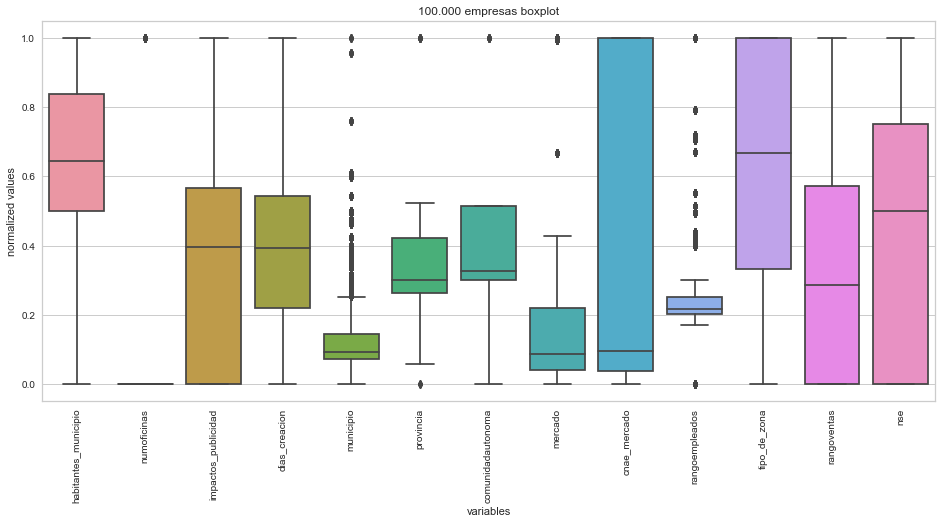

In [27]:
########## feature boxplots 
# Temos que quitar las varaibles binarias

df_boxplot = df_entero[predictores_num  + predictores_impact + predictores_ordinarios]

plt.figure( figsize=(16, 7))
plt.title("100.000 empresas boxplot")
sns.set_style("white")
bx_plot = sns.boxplot(data=df_boxplot)
plt.xticks(rotation=90)
plt.xlabel("variables")
plt.ylabel("normalized values")
plt.show()

Para ciertas variable existen outliers en su distribución, no los vamos a eliminar ni a realizar trasformaciones.

Algunos modelos (LM, GLM, ...) se ven perjudicados si incorporan predictores altamente correlacionados (y así evitar problemas de multicolinealdiad). Por esta razón, es conveniente estudiar el grado de correlación entre las variables disponibles.

In [28]:
df_corr = pd.concat([df_entero, df['Target']], axis=1)[:100000]

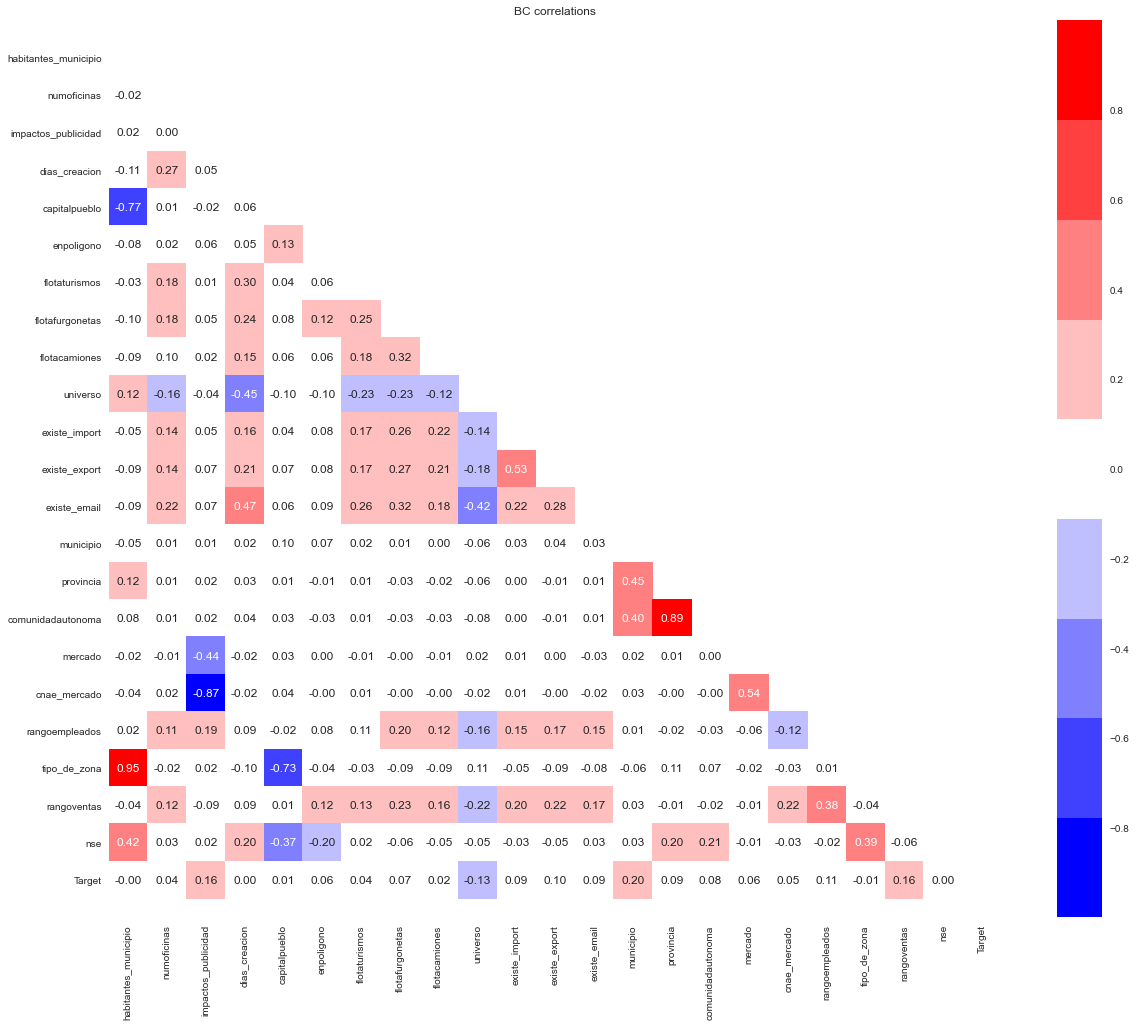

In [29]:
# define color map
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# define heatmap figure
plt.figure( figsize=(20, 16.5))
plt.title('BC correlations')
h_map = sns.heatmap(df_corr.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    fmt='.2f',
                    mask = np.triu(np.ones_like(df_corr.corr(), dtype=np.bool)),
                    xticklabels=list(df_corr.select_dtypes(include=np.number)),
                    yticklabels=list(df_corr.select_dtypes(include=np.number)))
plt.xticks(rotation=90) 

# put ticks on the color map bar
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# fix a few things
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

# generate the picture
plt.show()

* Las variables **'habitantes_municipio'** y **'tipo_de_zona'** están muy correladas, es lógico ya que al pertenecer a areas más complejas/importatnes el número de habotatnes será mayor. Ambos predictores no guardan ninguna relación con el Target, asi que **eliminamos** la varaible **'tipo_de_zona'**.

* Las varaibles **'Provincia'** y **'comunidadautonoma'**, las provincias pertenecen a comunidades autónomas. Son datos redundantes pero más agregados. Vamos a **eliminar la variable CCAA** ya que tiene menos correlación con el Target.

* Vemos también una relación muy fuerte entre **'cnae_mercado'** y **'impactos_publicitarios'**. No sabemos porque esa relación a priori.

In [30]:
clientes.drop(['tipo_de_zona', 'comunidadautonoma'], axis = 1, inplace=True)
clientes_potenciales.drop(['tipo_de_zona', 'comunidadautonoma'], axis = 1, inplace=True)
df_entero.drop(['tipo_de_zona', 'comunidadautonoma'], axis = 1, inplace=True)

## 2. Construir un modelo que detecte la propensión de las empresas de DataCentric a convertirse en clientes de la “empresa E”.


Para la resolución de este problema vamos a utilizar dos aproximaciones. La primera calculando  las distancias de los clientes potenciales a los grupos de clientes. Y la segunda como un problema de clasificación. Finalmente uniremos las dos estrategias como si de un Ensamble se tratase.

## 2.1 Clustering

<img src="cluster.PNG">

La primera aproximación que vamos a realizar para conocer los clientes potenciales es a traves de **Técnicas no supervisadas**, concretamente **Clustering**.

Vamos a crear grupos (los que sean necesarios) de nuestro clientes. Es decir **aplicar Clustering a las empresas que son clientes de la emrpesa E**. Una vez definidos estos grupos y sus **centroides**, vamos a calcular las **distancias del resto de empresas a los centroides** y quedarnos con la mínima distancia a cualquierla de los centroides para cada empresa. Solo faltará definir el **punto de corte (threshold)**, en base a la distribución de las distancias, para saber el número de clientes potenciales y poder ordenador según esa distancia.

In [31]:
pca_df, _ = perform_pca(df_entero, None)

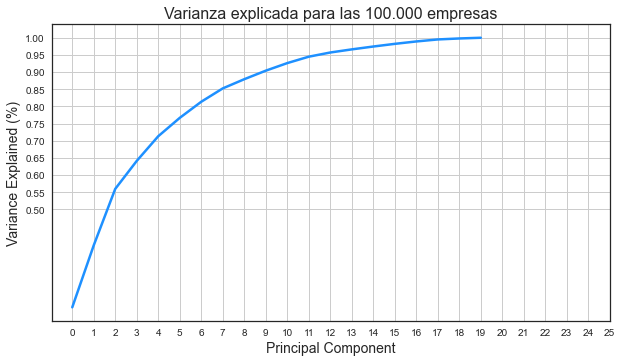

In [32]:
plot_pca_results(pca_df, pca_df)

Utilizamos técnicas de reducción de la dimensionalidad **(PCA)**, para reducir el número de variables de forma que pasemos a tener el mínimo número de nuevas variables y que representen a todas las antiguas variables de la forma más representativa posible. Vamos a coger las **10 primeras componentes, ya que explica mas del 90% de nuestros datos**.

In [33]:
pca_df_potenciales_10, X_df_potenciales_pca_10 = perform_pca(clientes_potenciales, n_components=10)
pca_df_clientes_10, X_df_clientes_pca_10 = perform_pca(clientes, n_components=10)

**PCA con 10 componentes de los potenciales clientes.**

In [34]:
X_df_potenciales_pca_10

array([[-0.74601073,  0.26132182, -0.10827567, ...,  0.05582953,
        -0.02128561, -0.01328858],
       [-0.25672525,  0.30154912, -0.84830738, ...,  0.02087198,
         0.00115438, -0.0278954 ],
       [ 0.85512803, -0.74830738, -0.37121593, ...,  0.05998982,
         0.28560366,  0.16466237],
       ...,
       [ 1.03596039,  0.66293273, -0.26471754, ..., -0.36331473,
         0.23936376,  0.37037563],
       [ 0.0441578 ,  0.73670522,  0.76379505, ...,  0.53439531,
        -0.4205232 ,  0.06123033],
       [-0.65386344, -0.55004894,  0.70945439, ..., -0.27705491,
        -0.15586363, -0.07937758]])

**PCA con 10 componentes de los clientes.**

In [35]:
X_df_clientes_pca_10

array([[ 0.27487115,  0.98452239, -0.39346237, ..., -0.17880775,
        -0.35887521, -0.12090094],
       [-0.40778788,  0.64586625, -0.52996358, ...,  0.05239966,
         0.03453616, -0.09340683],
       [ 0.56295745,  0.3298956 , -0.38308957, ..., -0.50283394,
        -0.45888214, -0.10217302],
       ...,
       [ 0.94550239, -0.21805427,  0.51270807, ..., -0.84604705,
         0.05343113, -0.42073214],
       [-0.05018911, -0.28622815, -0.50438131, ...,  0.04366677,
         0.12926314,  0.06344278],
       [ 0.77317151,  0.30816345, -0.37459074, ...,  0.36588735,
        -0.37155595, -0.49571416]])

### 2.1.2  k-means clustering

Para determinar el número de Clusters, exiten varias métricas. Vamos a aplicar algunas de ellas:

#### Método de Elbow

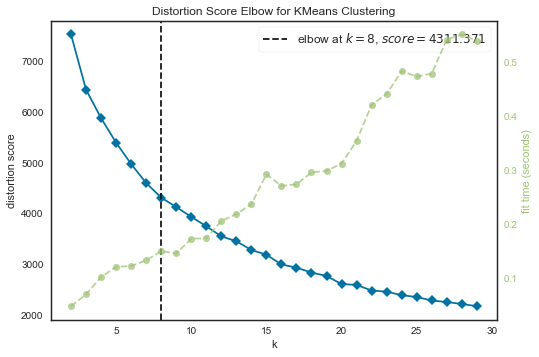

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(X_df_clientes_pca_10)        
visualizer.show()       

**Resultado:** k = 11

#### Método de silhouette

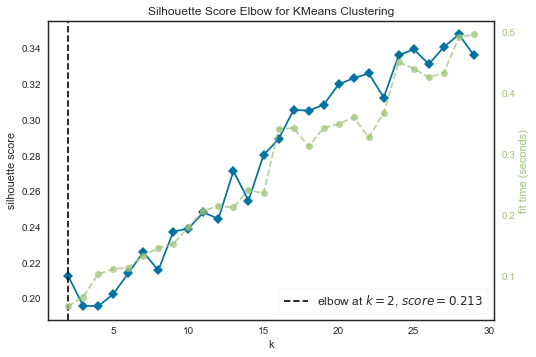

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [37]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(X_df_clientes_pca_10)
visualizer.show()

**Resultado:** k = 2

#### Método de calinski_harabasz

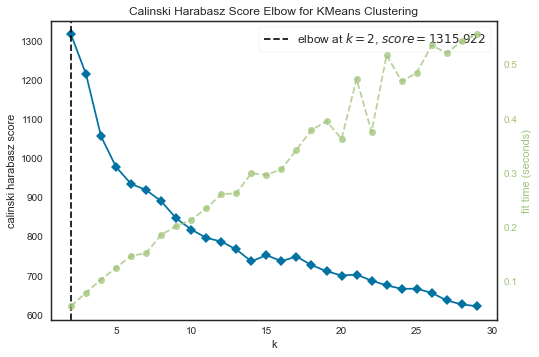

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [38]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X_df_clientes_pca_10)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**Resultado:** k = 2

#### Dendograma

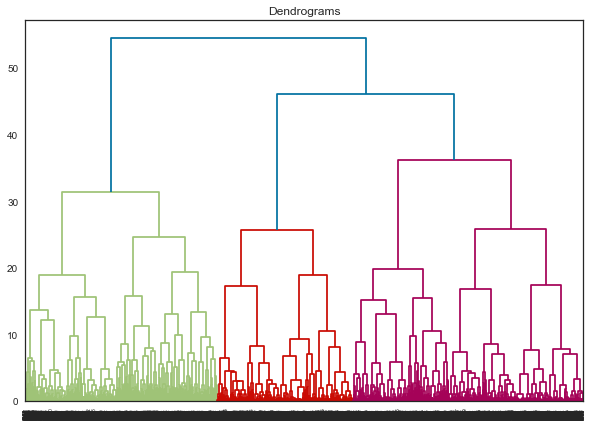

In [39]:
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_df_clientes_pca_10, method='ward'))

**Resultado:** k = 3

#### Representación de silhouette para varios clusters

For n_clusters = 2 The average silhouette_score is : 0.21263946575419973
For n_clusters = 3 The average silhouette_score is : 0.19626847372329806
For n_clusters = 4 The average silhouette_score is : 0.19936660676660445
For n_clusters = 5 The average silhouette_score is : 0.20236461058771743
For n_clusters = 6 The average silhouette_score is : 0.2154804961054352
For n_clusters = 7 The average silhouette_score is : 0.22326180215954583
For n_clusters = 8 The average silhouette_score is : 0.21530887199336107
For n_clusters = 9 The average silhouette_score is : 0.23341074619477598
For n_clusters = 10 The average silhouette_score is : 0.2316557574089634
For n_clusters = 11 The average silhouette_score is : 0.24126420581657165
For n_clusters = 12 The average silhouette_score is : 0.24345341944799898
For n_clusters = 13 The average silhouette_score is : 0.2617731900544691
For n_clusters = 14 The average silhouette_score is : 0.27745318495196725


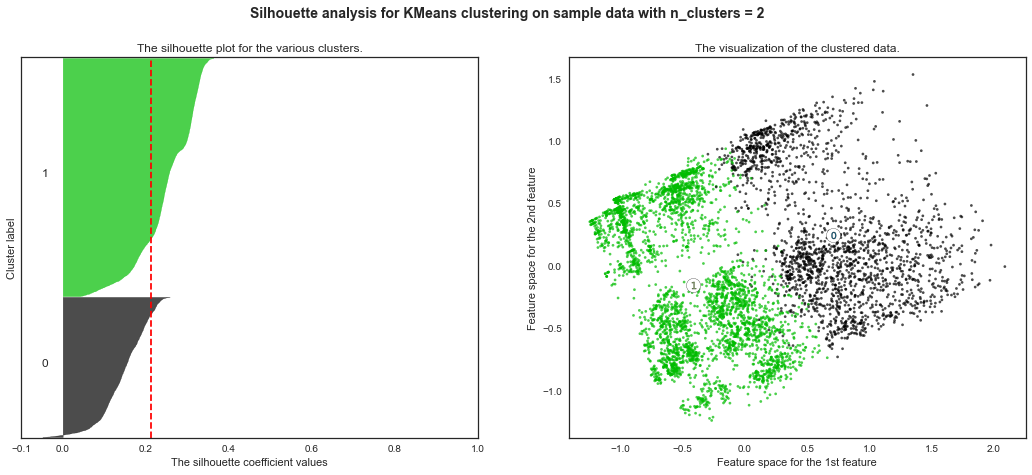

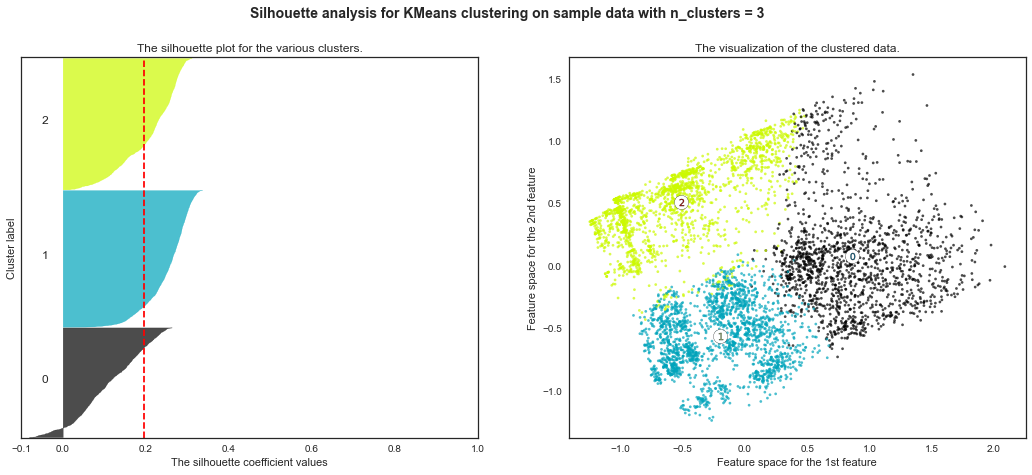

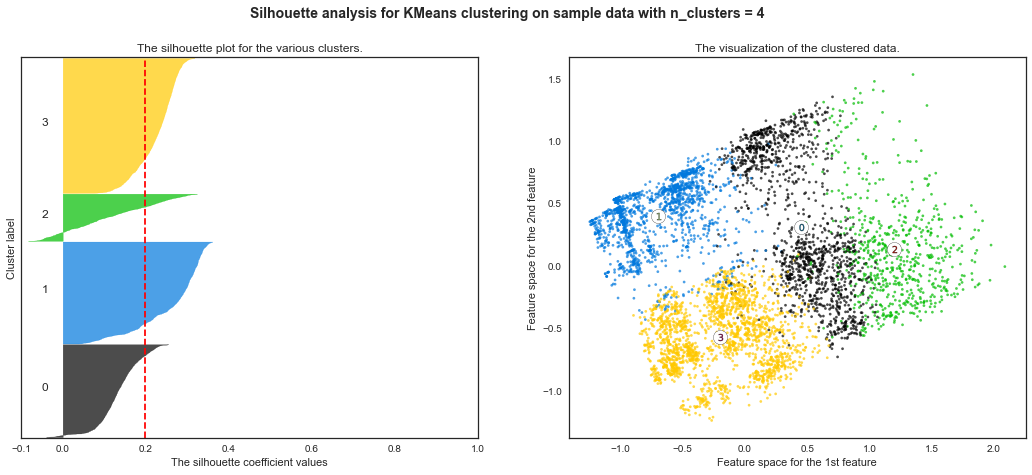

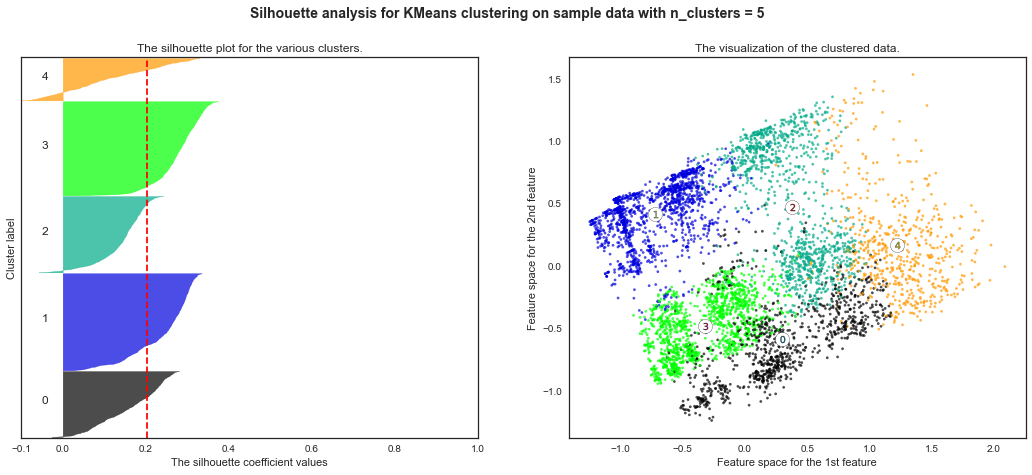

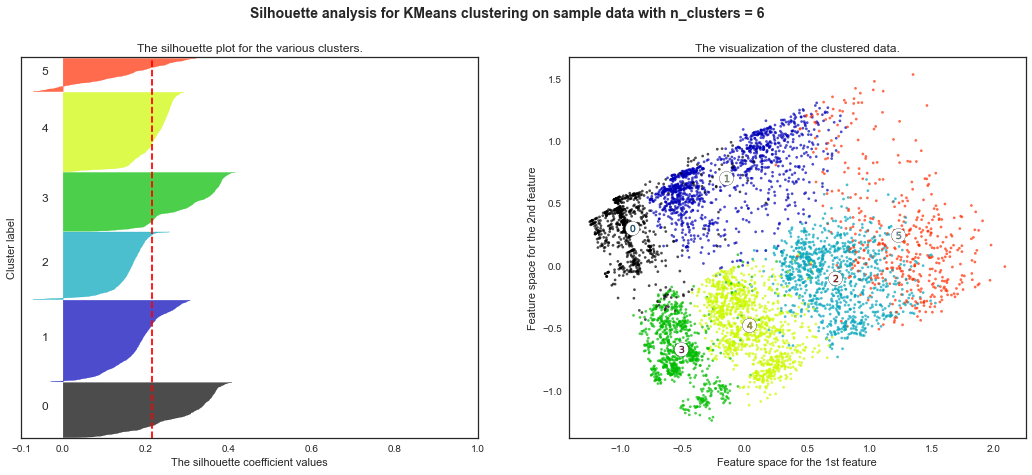

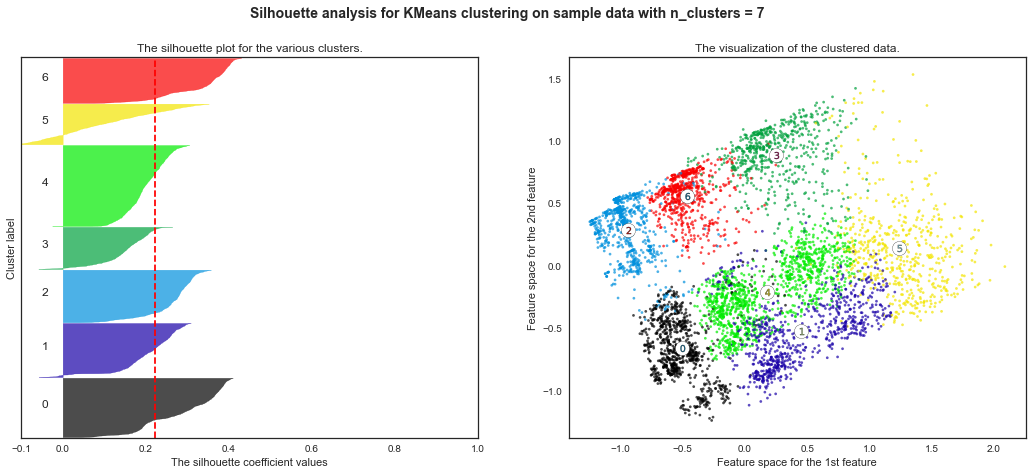

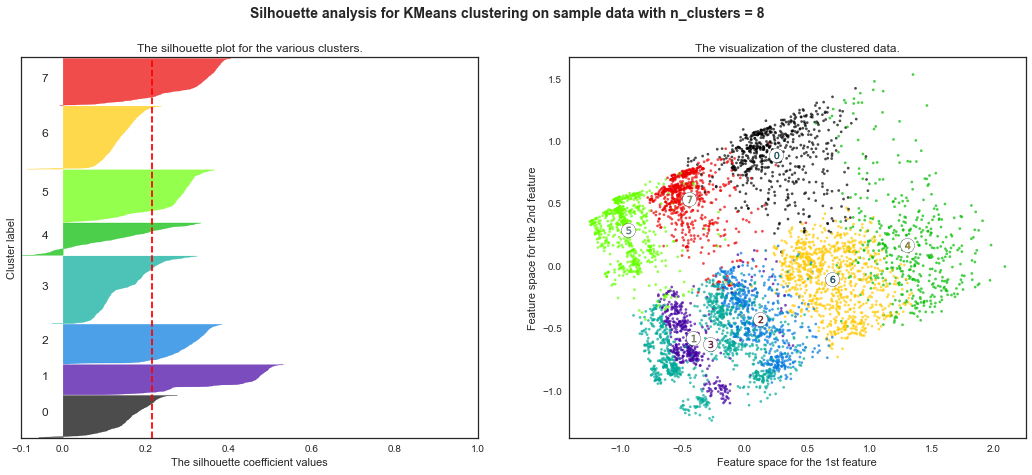

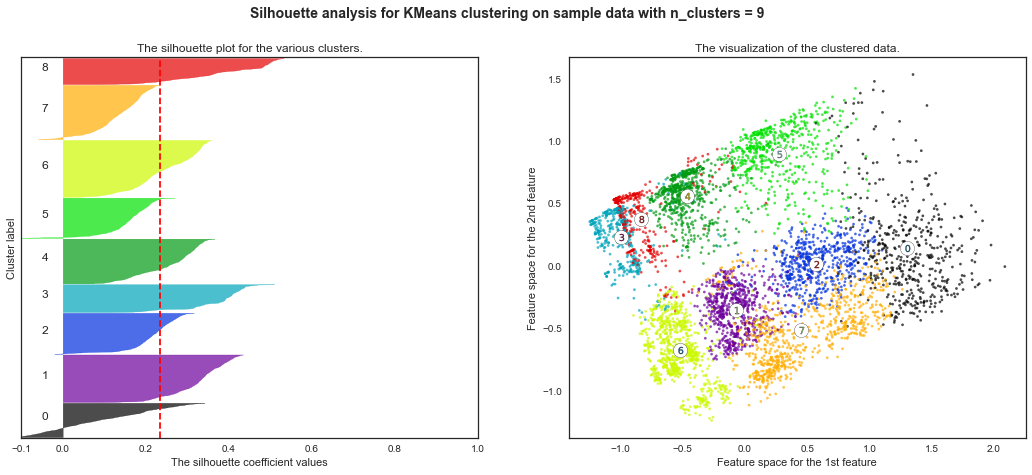

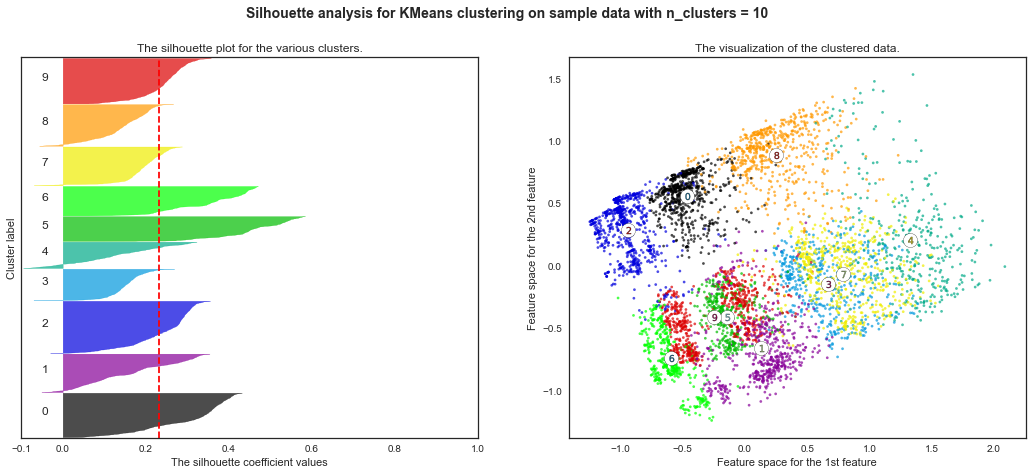

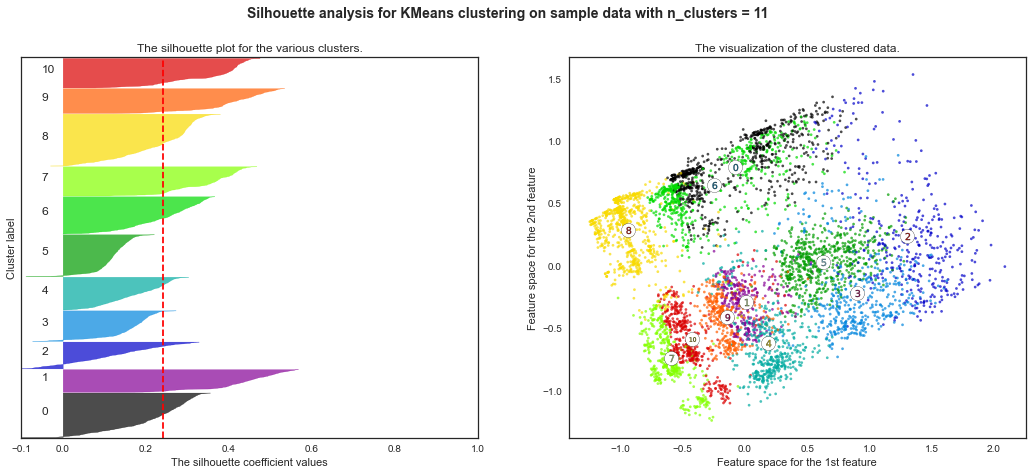

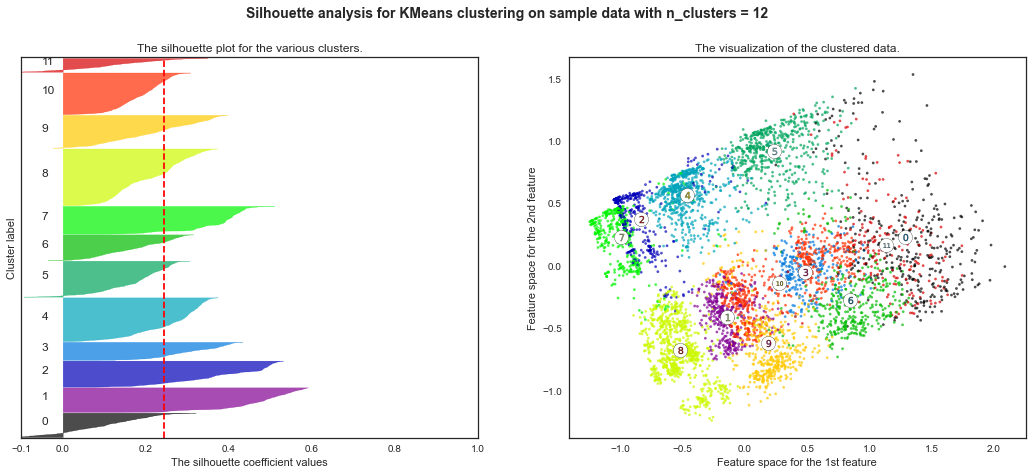

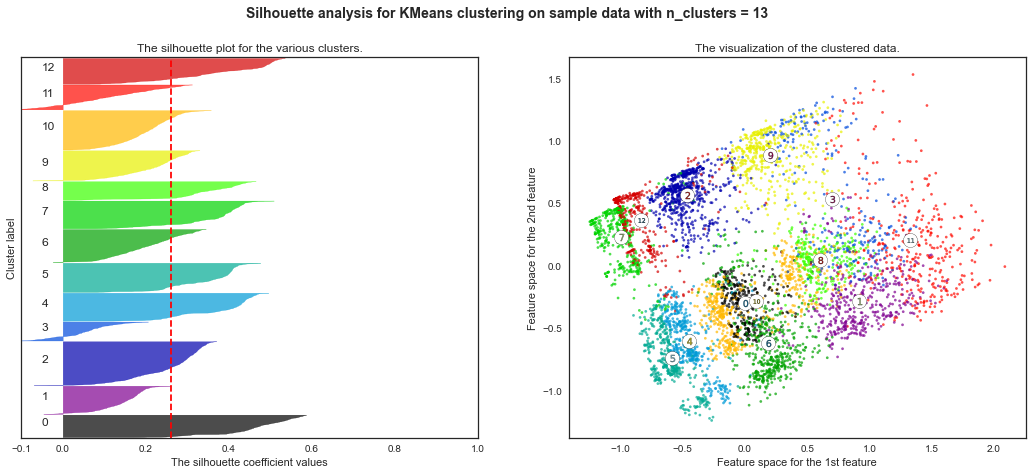

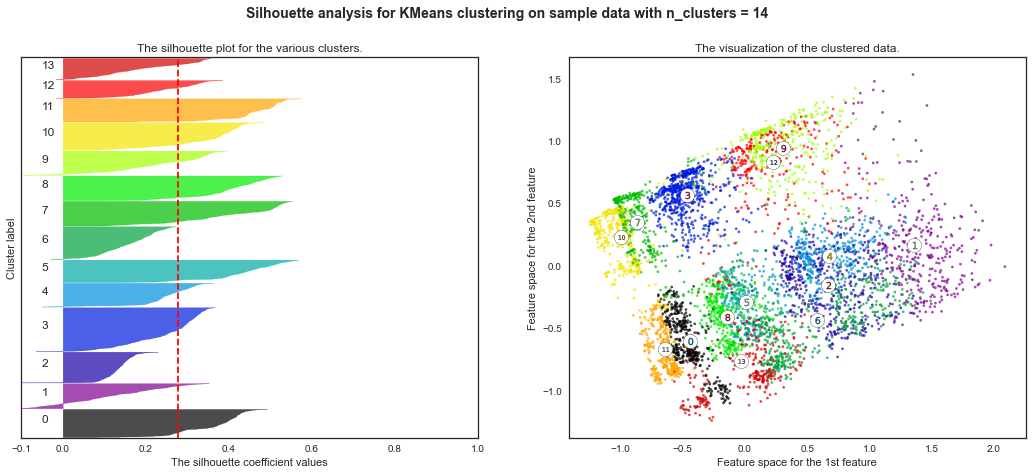

In [40]:
plot_silhoutte(X_df_clientes_pca_10)

**Resultado:** k = 2

Con la combinación de éstas métricas decidimos que el número de **clusters óptimo es 2**.

### 2.1.3 Realizamos la agrupación de k-means para el conjunto de datos de los clientes.

In [41]:
# Let us apply k-means clustering
kmeans_customers = KMeans(n_clusters=2, max_iter=400, n_init=20, random_state=42)
pred_y_customers = kmeans_customers.fit(X_df_clientes_pca_10)

In [42]:
# Cetroids of clusters
cluster_1 = pred_y_customers.cluster_centers_[0]
cluster_2 = pred_y_customers.cluster_centers_[1]

In [43]:
labels = list(pred_y_customers.labels_)

**¿ Como se distribuyen las empresas en los clusters?**

In [44]:
unique, counts = np.unique(labels, return_counts=True)
cust_number_clusters = pd.DataFrame(list(zip(unique, counts)),columns = ['cluster','number_of_customers']) 
cust_number_clusters['cluster'] = cust_number_clusters['cluster'] + 1
cust_number_clusters

,cluster,number_of_customers
0,1,1958
1,2,3320


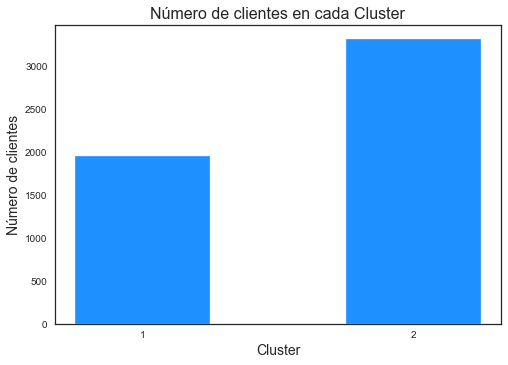

In [45]:
plt.bar(cust_number_clusters['cluster'], cust_number_clusters['number_of_customers'],
        width = 0.5, color='dodgerblue') 
plt.xlabel("Cluster", fontsize=14) 
plt.ylabel("Número de clientes", fontsize=14) 
plt.title("Número de clientes en cada Cluster", fontsize=16) 
plt.xticks(np.arange(1, 3))
plt.show() 

El cluster 2 tiene una gran parte de los clientes.

### 2.1.4  Calculámos las distancias euclidianas entre los centroides y la población general.

In [46]:
dist_cluster_1 = find_distance(X_df_potenciales_pca_10, cluster_1)
dist_cluster_2 = find_distance(X_df_potenciales_pca_10, cluster_2)

In [47]:
empresas_dist = pd.DataFrame({'id':list(clientes_potenciales.index),
                            'dist_to_cluster_1':dist_cluster_1,
                            'dist_to_cluster_2':dist_cluster_2})

In [48]:
empresas_dist = define_index(empresas_dist)

In [49]:
empresas_dist

,dist_to_cluster_1,dist_to_cluster_2
id,,
0,1.687761,0.792937
1,1.542802,1.284281
2,1.469800,1.678085
3,1.779265,0.935538
4,1.783910,0.973596
...,...,...
94717,0.949503,1.571417
94718,1.571175,0.710246
94719,1.238766,1.897273


### 2.1.4 Clientes Potenciales

Representamos como se distribuye cada punto, cada empresa,  frente a la distancia a cada uno de los dos centroides.

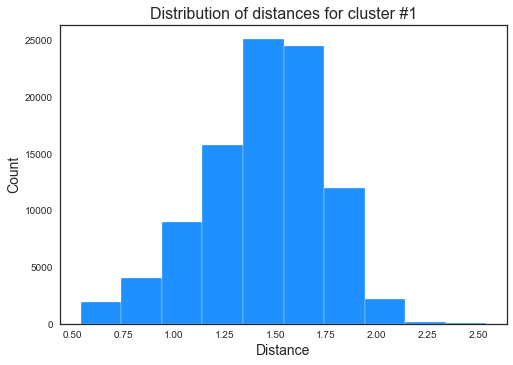

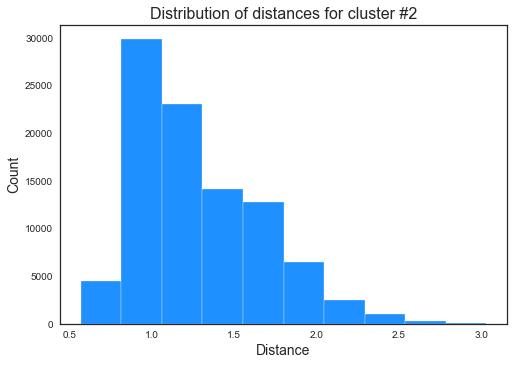

In [50]:
for columna in empresas_dist.columns:

    # Let's have a look at distribution of distances
    plt.hist(data=empresas_dist, x= columna, color='dodgerblue')
    plt.xlabel('Distance', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f"Distribution of distances for cluster #{columna[-1:]}", fontsize=16)
    plt.show()

In [51]:
empresas_describe = empresas_dist.describe()
empresas_describe

,dist_to_cluster_1,dist_to_cluster_2
count,94722.000000,94722.000000
mean,1.448129,1.282599
std,0.293525,0.380356
min,0.539928,0.569587
25%,1.275605,0.960413
50%,1.487819,1.226486
75%,1.661736,1.549092
max,2.540433,3.032503


Definimos cual es la **distancia minima** y cual la **distancia máxima** de cualquiera de los punto frente a cualquiera de los centroides. Esto lo vamos a utilizar para calcular el threshold.

In [52]:
distancia_maxima = empresas_describe.loc[empresas_describe.index == 'max', :].values.max()
distancia_minima = empresas_describe.loc[empresas_describe.index == 'min', :].values.min()

### 2.1.5  Establecer un umbral para las distancias euclidianas

Observando los histogramas y la tabla, podemos decir que la **distancia mínima es de 0.62**, mientras que la **máxima es de 3.04**. El **valor medio está en torno a 1.4.**

**Vamos a representar para cada punto de corte, el número de empresas que serían clientes para ese corte, y el número de clientes ganados.**

In [53]:
corte = []
numero_empresas = []

for i in list(np.arange(distancia_minima ,distancia_maxima, 0.05)):
    
    # Choose potential customers based on threshold value
    potential_customers_1 = empresas_dist.loc[empresas_dist['dist_to_cluster_1'] <= i]
    potential_customers_2 = empresas_dist.loc[empresas_dist['dist_to_cluster_2'] <= i]
 
    potential_customers = pd.concat([potential_customers_1, potential_customers_2], ignore_index=True)
    
    corte.append(i)
    numero_empresas.append(len(potential_customers.drop_duplicates()))
    

In [54]:
distribucion_empresas_corte = pd.DataFrame({'Corte': corte, 'Nºempresas': numero_empresas})

In [55]:
ganancia_empresas = resta_consecutivos(distribucion_empresas_corte['Nºempresas'])
distribucion_empresas_corte['ganancia_empresas'] = ganancia_empresas

In [56]:
distribucion_empresas_corte.head()

,Corte,Nºempresas,ganancia_empresas
0,0.539928,1,0
1,0.589928,87,86
2,0.639928,640,553
3,0.689928,1500,860
4,0.739928,2824,1324


**Lo representamos gráficamente:**

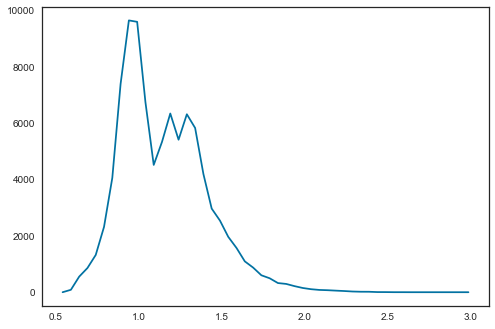

In [57]:
plt.plot(distribucion_empresas_corte.Corte, distribucion_empresas_corte['ganancia_empresas'])

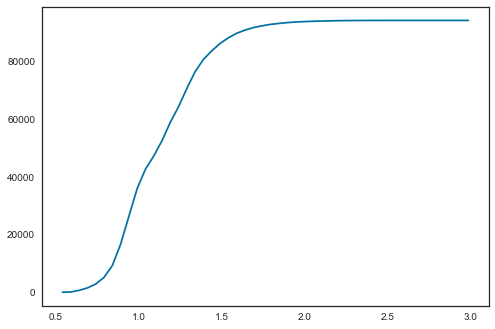

In [58]:
plt.plot(distribucion_empresas_corte.Corte, distribucion_empresas_corte['Nºempresas'])

**Tomamos como threshold, el punto de corte dónde más empresas se ganan.**

In [268]:
# Sacamos el punto de Corte optimo
punto_corte = float(distribucion_empresas_corte[distribucion_empresas_corte.ganancia_empresas ==
                                  distribucion_empresas_corte.ganancia_empresas.max()]['Corte']) 

In [269]:
punto_corte

0.9399284679576632

In [270]:
potential_customers_1 = empresas_dist.loc[empresas_dist['dist_to_cluster_1'] <= punto_corte]
potential_customers_2 = empresas_dist.loc[empresas_dist['dist_to_cluster_2'] <= punto_corte]

In [271]:
potential_customers = pd.concat([potential_customers_1, potential_customers_2], ignore_index=True).drop_duplicates()

In [272]:
potential_customers['Distancia_minima'] = potential_customers.min(axis = 1)

In [273]:
df_cluster = potential_customers.sort_values(by='Distancia_minima')
df_cluster

,dist_to_cluster_1,dist_to_cluster_2,Distancia_minima
1547,0.539928,1.523631,0.539928
5985,0.542201,1.516200,0.542201
3775,0.548539,1.522177,0.548539
3531,0.550899,1.514369,0.550899
3143,0.552635,1.533341,0.552635
...,...,...,...
8710,1.480008,0.939911,0.939911
7178,1.648905,0.939914,0.939914
12386,1.851469,0.939918,0.939918
9693,1.496246,0.939924,0.939924


### 2.1.6 Identificar los clusters de pertenencia de los clientes potenciales.

In [65]:
potential_customers.loc[potential_customers['dist_to_cluster_1'] == potential_customers['Distancia_minima'],
                        'cluster'] = 1
potential_customers.loc[potential_customers['dist_to_cluster_2'] == potential_customers['Distancia_minima'],
                        'cluster'] = 2

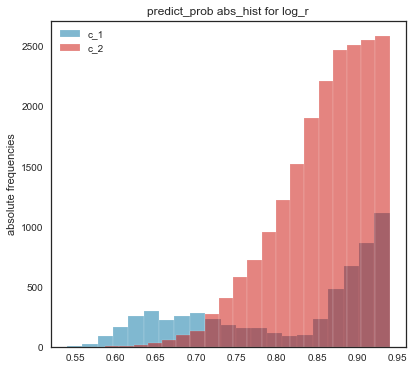

In [66]:
c_1 = potential_customers[potential_customers.cluster == 1]['Distancia_minima']
c_2 = potential_customers[potential_customers.cluster == 2]['Distancia_minima']

bins = 21

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("predict_prob abs_hist for log_r")
plt.ylabel("absolute frequencies")
plt.hist( c_1, bins=bins, density=False, color='b', label='c_1', alpha=0.5)
plt.hist( c_2, bins=bins, density=False, color='r', label='c_2', alpha=0.5)
plt.legend(loc='best')


plt.show()

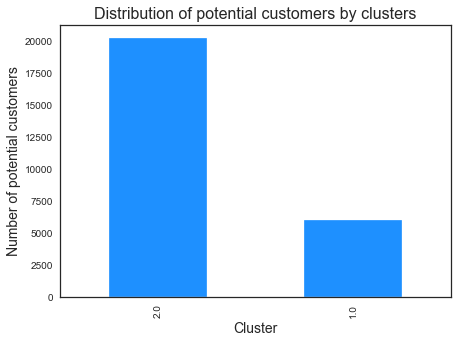

In [67]:
fig = plt.figure(figsize=(7, 5))
potential_customers['cluster'].value_counts().plot.bar(color='dodgerblue');
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of potential customers', fontsize=14)
plt.title("Distribution of potential customers by clusters", fontsize=16);

Hay **más muchos más clientes potenciales en el cluster 2**, pero vemos en la ditribución que los **clientes potenciales 'más faciles' (con una distancia menor) se encuentran en el primer cluster**. Sería interesante aprender más sobre este cluster.

# Conclusiones:

* Utilizando la agrupación de k-means y el método del codo, dendograma, método de calinski_harabasz y más  se encontraron **2 clusters dentro de los clientes existentes**.

* Aplicando las **distancias euclidianas** se encontraron las distancias entre los centroides de los clusters y las empresas del conjunto de datos de los potenciales clientes.

* Establecí un **umbral = 0.93** para definir a los clientes potenciales, el umbral es la distancia dónde más clientes se ganan. El umbral se puede ajustar, en función del coste que tenga captar nuevos clientes. 

* Según el modelo de agrupación de k-means, la **partición de clientes en los dos clusters es una superior a la otra (70% C.2 , 30% C.1)**.

* En total, se encontraron **26.249 clientes potenciales**, que representan aproximadamente el **26% de la población general**.

* Hay **más muchos más clientes potenciales en el cluster 2**, pero vemos en la ditribución que los **clientes potenciales 'más faciles' (con una distancia menor) se encuentran en el primer cluster**. Sería interesante aprender más sobre este cluster.



# 2.2 Problema de Clasificación

Podemos abordar el problema como un problema de clasificación, es decir, sabemos el número de veces que la Empresa_E ha contactado con cada una de las empresas. Y ha contactado con una intención publicitaria. Entonces suponemos, para la creación del Target que:

* Si es cliente, el Target es postivo (1).
* Si tiene impactos publicitarios mayores que 0 y no es cliente, la captación ha fracasado. Así pues, Target negativo (0).
* Y si no tiene impactos publicitarios, es un potencial cliente.

In [199]:
df_clasificacion = pd.concat([df_entero, df['Target']], axis = 1)[:100000]

El **Dataset está imbalanceado**, es decir, la clase positiva es muy inferior (a razón de 10) a la clase negativa.

In [200]:
# ¿ Dataset imbalanceado?
print(f'Observaciones con clase positiva {sum(df_clasificacion.Target == 1)}')
print(f'Observaciones con clase Negativa {sum(df_clasificacion.Target == 0)}')

Observaciones con clase positiva 5278
Observaciones con clase Negativa 56881


**Es muy importante eliminar la variable impactos_publicidad, ya que la hemos utilizado para crear el Target**

**Separamos nuestros datos en:**

* **Train**: conjunto de datos que usaremos para entrenar el modelo.
* **Validación**: conjunto de datos que usaremos para calcular la métrica de error y ajustar los hiper-parámetros para mejorar ese error.
* **Test**: conjunto de datos dónde aplicaremos el modelo entrenado.


**El conjunto de Test estará formado por las observaciones que tienen el campo Target nulo.**

In [201]:
# Imputs de TEST
X_test = df_clasificacion[df_clasificacion.Target.isna()].drop('Target', axis = 1)

In [202]:
print(f'Observaciones en el conjunto de Test {len(X_test)}')

Observaciones en el conjunto de Test 37841


In [340]:
X = df_clasificacion[(df_clasificacion.Target == 1) | (df_clasificacion.Target == 0)].drop('Target', axis = 1)
y = df_clasificacion[(df_clasificacion.Target == 1) | (df_clasificacion.Target == 0)]['Target']

**Separamos el resto de datos en Train y Validación.**

En general, el método de evaluación del rendimiento de la validación cruzada **k-fold** se basa en la suposición de que - cada pliegue de datos es una muestra representativa de los datos principales y refleja la distribución de clases de la característica objetivo en los datos principales. En definitiva, asume que la distribución de clases de la característica objetivo en los datos principales es 50:50.

Sin embargo, la **aplicación de esta regla a un problema de clasificación desequilibrado plantea un problema de distribución que podría dar lugar a una estimación sesgada o a un sobreajuste** a favor de la clase mayoritaria. El uso correcto de la validación cruzada k-fold en un problema de distribución de clases desequilibradas, requiere:

* Que cada dato k-fold se estratifique para capturar la distribución de clase desequilibrada de la característica objetivo en los datos principales. Esto puede lograrse utilizando la validación cruzada estratificada de k pliegues;

* Que, en cada evaluación de validación cruzada, sólo se sobremuestree el conjunto de entrenamiento (utilizando la técnica de sobremuestreo de minorías sintéticas u otras técnicas de equilibrio de clases). 
* Que, en cada evaluación de validación cruzada, los datos de validación no sean sobremuestreados, es decir, que no se vean afectados por el sobremuestreo, aunque mantengan la distribución de clases desequilibrada de la característica objetivo como en los datos principales;

* Que el sobremuestreo nunca se realice en los datos principales, sino en el conjunto de datos de entrenamiento, durante cada evaluación de validación cruzada k-fold.



In [204]:
# División
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

Creamos un **modelo Base Line**, en nuestro caso una **regresión logística**.

In [168]:
# Baseline
baseline = LogisticRegression(random_state=42)
baseline.fit(X_train, y_train)

baseline_prediccion_train = baseline.predict(X_train)
baseline_prediccion = baseline.predict(X_val)

recall_baseline = recall_score(y_val, baseline_prediccion, average='binary') 
recall_baseline_train = recall_score(y_train, baseline_prediccion_train, average='binary')

print(f'Recall: {recall_baseline}')
print(f'Recall train: {recall_baseline_train}')

Recall: 0.2810693641618497
Recall train: 0.31535695942475606


Rendimiento muy pobre. Solo acertamos el **28%** de todas las empresas que realmente son clientes.

Al no tener la **matriz de costos**, no podemos definir una función de costes asociada a este problema para obtimizarla. Nos tenemos que ajustar a las ya existentes. En este problema queremos captar el **mayor número de clientes positivos**, aunque pequemos de  equivocarnos en la clase mayoritaria. Osea **Recall**, ya que el coste de de equivocarnos y hacer una acción publicitaria intuimos que es baja.


La mayoría de los **algoritmos de aprendizaje automático no son muy útiles con datos de clase sesgados**. Pero podemos modificar 
el algoritmo de entrenamiento actual para tener en cuenta la distribución sesgada de las clases. Esto se puede lograr dando 
diferentes pesos a las clases mayoritarias y minoritarias. **La diferencia de pesos influirá en la clasificación de las clases 
durante la fase de entrenamiento**. El propósito es penalizar la clasificación errónea hecha por la clase minoritaria 
estableciendo un peso de clase más alto y al mismo tiempo reduciendo el peso para la clase mayoritaria.

El parámetro **class_weights = 'balanceado'** asigna automáticamente los pesos de clase inversamente proporcionales a sus 
respectivas frecuencias.

Además usaremos **técnicas de remuestro** para balancear las clases, realizaremos el **sobremuestreo** de la clase minoritaria, concretamente, el método de sobremuestreo sintético de minorías **(SMOTE)**.


Hemos dicho que el desequilibrio de clases se ignora a nivel de algoritmo ajustando el coste de las clases para contrarrestar el desequilibrio (class_weights = 'balanceado'). **En este caso usaremos ambos métodos, el de coste y el de remuestreo, para proporcionar un mejor rendimiento**.

In [205]:
# ¿ Dataset imbalanceado?
print(f'Observaciones con clase Positiva train {sum(y_train == 1)}')
print(f'Observaciones con clase Negativa train {sum(y_train == 0)}')

Observaciones con clase Positiva train 3894
Observaciones con clase Negativa train 42725


In [206]:
sm = SMOTE(random_state=42, sampling_strategy=0.9)
X_train, y_train = sm.fit_resample(X_train, y_train)

**Aplicamos SMOTE (Con un coeficiente de 0.9, para que siga existiendo una clase minoritaria, pero mucho menos sesgada)**.

In [77]:
# ¿ Dataset imbalanceado?
print(f'Observaciones con clase Positiva train {sum(y_train == 1)}')
print(f'Observaciones con clase Negativa train {sum(y_train == 0)}')

Observaciones con clase Positiva train 38452
Observaciones con clase Negativa train 42725


In [ ]:
X_train = X_train.drop(['impactos_publicidad'], axis = 1)
X_val = X_val.drop(['impactos_publicidad'], axis = 1)
X_test = X_test.drop(['impactos_publicidad'], axis = 1)

Una vez hecho el **pre-procesado (Apartado 1)**, definido cual es la **métrica de error a optimizar**, definidos los **conjuntos de datos** y **balanceado el dataset**, vamos a utilizar varios **algoritmos de ML** para resolver el problema de clasificación y ver cual funcionar mejor. Para después hacer el ajuste de hiperparámetros. Los modelos que vamos a usar son:

* RandomForest
* ExtraTreesClassifier
* LogisticRegression
* Adaboost
* GradientBoosting
* xgb
* catboost
* lgbm
* MLPClassifier (red neuronal)
* StackingClassifier

Todos los modelos utilizan RandomizedSearchCV para encontrar los mejores hiperparámetros en 12 iteraciones.

In [136]:
rs = 42
ntrees = 50

models = {
    "randomForest": {
        "class" : RandomForestClassifier(random_state=rs, class_weight = 'balanced'),
        "param_dist" : {
            "n_estimators" : [50, 100, 500, 1000],
            "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"]
        }
    },
    'ExtraTreesClassifier': {
        'class': ExtraTreesClassifier(random_state=rs, class_weight = 'balanced'),
        "param_dist" : {
            'class_weight': ['balanced'],
            "n_estimators" : [ntrees],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [1, 2, 4, 6, 8, 16, 32],
            "min_samples_leaf": [1, 2, 4, 6, 8, 16, 32],
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"]
        }
    },
    'LogisticRegression': {
        'class': LogisticRegression(random_state=rs, class_weight = 'balanced'),
        "param_dist" : {
            "penalty": ['l2']
        }
    },
       "gradientBoosting": {
           "class" : GradientBoostingClassifier(random_state=rs),
           "param_dist" : {
               "n_estimators" : [ntrees],
               "loss": ["deviance", "exponential"],
               "learning_rate": np.logspace(-5,0,12),
               "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
               "min_samples_split": [2, 4, 8, 16, 32, 64],
               "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
               "subsample" : [0.1, 0.2, 0.5, 0.9, 1],
               "max_features": ["sqrt", "log2", None],
         }
     },
     "xgb": {
         "class" : XGBClassifier(random_state=rs, class_weight = 'balanced'),
         "param_dist" : {
             'n_estimators': [50, 100, 500, 1000],
             'gamma' : [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
             'max_depth': [6, 9, 12],
             'subsample': [0.5, 0.9, 1.0],
             'colsample_bytree': [0.5, 0.9, 1.0],
             'reg_lambda' : [0, 1e-3, 1e-2, 1e-1, 1, 10, 100]
         }
     },
     "catboost": {
         "class" : CatBoostClassifier(random_state=rs, verbose=0),
         "param_dist" : {
           'depth':[4,5,6,7,8,9,10],
           'iterations':[10,20,30,40,50,60,70,80,90,100],
           'learning_rate':[0.01,0.02,0.03,0.04]
        } 
     },
    
      "lgbm": {
          "class" : LGBMClassifier(random_state=rs, class_weight = 'balanced'),
          "param_dist" : {
              'learning_rate': [0.005, 0.01],
              'n_estimators': [8,16,24],
              'num_leaves': [6,8,12,16,50],
              'boosting_type' : ['gbdt', 'dart'], 
              'objective' : ['binary'],
              'max_bin':[255, 510], 
              'random_state' : [500],
              'colsample_bytree' : [0.64, 0.65, 0.66],
              'subsample' : [0.7,0.75],
              'reg_alpha' : [1,1.2],
              'reg_lambda' : [1,1.2,1.4]
        } 
    },
    
    "MLPClassifier": {
          "class" : MLPClassifier(random_state=rs),
          "param_dist" : {
        } 
    }
    
    
    
#    'Stacking': {
#        'class': StackingClassifier(
#            estimators =  [('lr',LogisticRegression(random_state=rs, class_weight = 'balanced')), 
#                           ('KN', KNeighborsClassifier()), 
#                       ('GradientB', GradientBoostingClassifier(random_state=rs)), 
#                           ('RF', RandomForestClassifier(random_state=rs, class_weight = 'balanced'))],
#        ),
#        'param_dist': {
#            'final_estimator': [LogisticRegression(random_state=rs, class_weight = 'balanced'),
#                                GradientBoostingClassifier(random_state=rs), 
#                                RandomForestClassifier(random_state=rs, class_weight = 'balanced')],
#            'stack_method': ['predict_proba'],
#        }
#    }
    
}

La **función de coste**, como hemos comentado, devuelve la puntuación de **recall**. Para determinar la pertenencia a una clase u a otra, toma como **threshold 0.5 (por defecto)**. **Pero es necesario comprobar, con la distribución de probabilidad de cada clase si es cierto. El histograma refleja que el punto 0.5 es el que mejor separa ambas clases.**

In [329]:
def score(X, y, Xte, yte, estimator_class):
    """Returns score over a test set"""
    
    y_score = estimator_class.predict(Xte)
    y_score_clase_negativa = estimator_class.predict_proba(Xte)[:,0]
    y_score_clase_positiva = estimator_class.predict_proba(Xte)[:,1]
    
    recall = recall_score(yte, y_score, average='binary')
    matriz_confusion = confusion_matrix(yte, y_score)

    
    y_score_train = estimator_class.predict(X)
    y_score_clase_negativa_train = estimator_class.predict_proba(X)[:,0]
    y_score_clase_positiva_train = estimator_class.predict_proba(X)[:,1]
    
    recall_train = recall_score(y, y_score_train, average='binary')
    matriz_confusion_train = confusion_matrix(y, y_score_train)
    
    return [recall, recall_train, matriz_confusion, matriz_confusion_train, y_score_clase_negativa, y_score_clase_positiva,
           y_score_clase_negativa_train, y_score_clase_positiva_train]

def tune_random(X, y, Xte, yte, estimator, param_dist, n_iter_search, n_jobs, k):
    """Performs hyperparameter tuning over an estimator and trains it"""
    start = time.time()
    
    estimator_class = RandomizedSearchCV(
    estimator = estimator,
    param_distributions = param_dist, n_iter = n_iter_search,
    scoring='recall', n_jobs=n_jobs, cv = None, refit=True, return_train_score = True, random_state=rs)
    
    estimator_class.fit(X, y)
    
    resultado = score(X, y, Xte, yte, estimator_class)
    end = time.time()
    scores = {
        'recall':resultado[0],
        'recall_train':resultado[1],
        'Matriz_confusion': resultado[2],
        'Matriz_confusion_train': resultado[3],
        'y_score_clase_negativa': resultado[4],
        'y_score_clase_postiva': resultado[5],
        'y_score_clase_negativa_train': resultado[6],
        'y_score_clase_positiva_train': resultado[7],
        'Elapsed time': (end-start)
    }
    return scores

In [330]:
n_jobs = -1
n_iter_search = 6
#k = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#k =2
modelscoring = {
        modelname : tune_random(
                        X_train, y_train,
                        X_val, y_val, 
                        models[modelname]["class"], 
                        param_dist=models[modelname]["param_dist"], 
                        n_iter_search=n_iter_search, 
                        n_jobs=n_jobs,
                        k = k
                    )
        for modelname in models
    }

[18:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [331]:
modelscoring = pd.DataFrame.from_dict(modelscoring, orient='index')
modelscoring = modelscoring.sort_values(by='recall', ascending=False)
modelscoring

,recall,recall_train,Matriz_confusion,Matriz_confusion_train,y_score_clase_negativa,y_score_clase_postiva,y_score_clase_negativa_train,y_score_clase_positiva_train,Elapsed time
LogisticRegression,0.672688,0.709352,"[[10103, 4053], [453, 931]]","[[30262, 12463], [11176, 27276]]","[0.9424329174919766, 0.4221957066547931, 0.664...","[0.057567082508023434, 0.5778042933452069, 0.3...","[0.361276946788353, 0.42826054890835197, 0.395...","[0.638723053211647, 0.571739451091648, 0.60407...",1.547777
MLPClassifier,0.593931,0.845990,"[[10738, 3418], [562, 822]]","[[32603, 10122], [5922, 32530]]","[0.9432513037566846, 0.8355806780158601, 0.906...","[0.056748696243315334, 0.1644193219841399, 0.0...","[0.24863937540530168, 0.5128693585963922, 0.31...","[0.7513606245946983, 0.4871306414036078, 0.680...",210.775392
ExtraTreesClassifier,0.537572,0.908223,"[[11784, 2372], [640, 744]]","[[36967, 5758], [3529, 34923]]","[0.9358023380199678, 0.694038548719552, 0.6297...","[0.064197661980032, 0.305961451280448, 0.37021...","[0.5384146543264144, 0.670396751039037, 0.3911...","[0.46158534567358556, 0.3296032489609629, 0.60...",40.618878
catboost,0.432081,0.833533,"[[12219, 1937], [786, 598]]","[[36902, 5823], [6401, 32051]]","[0.8128481911414279, 0.6441720793433074, 0.830...","[0.1871518088585721, 0.3558279206566925, 0.169...","[0.6522875285386884, 0.6132586628687855, 0.549...","[0.3477124714613115, 0.38674133713121445, 0.45...",39.991059
lgbm,0.349711,0.830048,"[[12753, 1403], [900, 484]]","[[38338, 4387], [6535, 31917]]","[0.5211611497485711, 0.5125915547150401, 0.515...","[0.47883885025142897, 0.48740844528495986, 0.4...","[0.5026591202098849, 0.5052191220790758, 0.504...","[0.49734087979011504, 0.4947808779209241, 0.49...",9.381464
gradientBoosting,0.147399,0.999740,"[[13685, 471], [1180, 204]]","[[42723, 2], [10, 38442]]","[0.999999999999888, 0.9999999999997042, 0.9999...","[1.119829815915076e-13, 2.9574903389477776e-13...","[0.9999999980034254, 0.9999999997115868, 0.999...","[1.996574603467282e-09, 2.884132037517948e-10,...",193.710357
xgb,0.145954,0.999714,"[[13700, 456], [1182, 202]]","[[42724, 1], [11, 38441]]","[0.9999599, 0.9998263, 0.9999183, 0.3338642, 0...","[4.0142895e-05, 0.0001736807, 8.172512e-05, 0....","[0.9995507, 0.9974455, 0.9813785, 0.9861413, 0...","[0.00044931096, 0.0025544623, 0.01862151, 0.01...",875.140405
randomForest,0.138006,0.999896,"[[13694, 462], [1193, 191]]","[[42717, 8], [4, 38448]]","[0.994, 0.99, 0.983, 0.618, 0.944, 1.0, 0.797,...","[0.006, 0.01, 0.017, 0.382, 0.056, 0.0, 0.203,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1175.244948


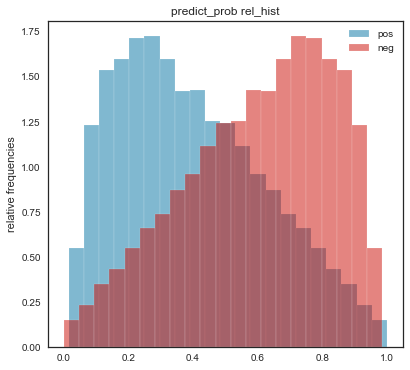

In [332]:
# Creamos un dataframe, que este la clase real, y la distribucion de probabilidad como columna

c_pos = modelscoring.iloc[0,5]
c_neg = modelscoring.iloc[0,4]
bins = 21

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
plt.title("predict_prob rel_hist")
plt.ylabel("relative frequencies")
plt.hist( c_pos, bins=bins, density=True, color='b', label='pos', alpha=0.5)
plt.hist( c_neg, bins=bins, density=True, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.show()

Para definir el threshold, representamos la distribución de probabilidades para cada clase. Vemos que el punto **0.5** es el que mejor discrimina.

**El threshold en este caso sería de 0,5.**

Matriz de confusión en Validación:


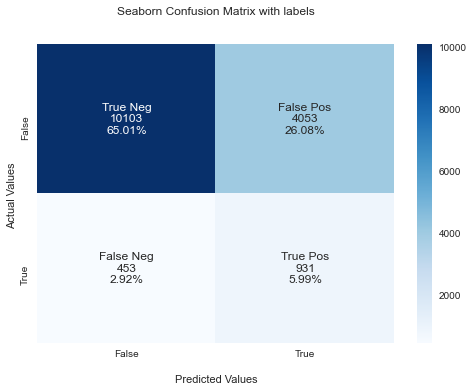

Matriz de confusión en Train:


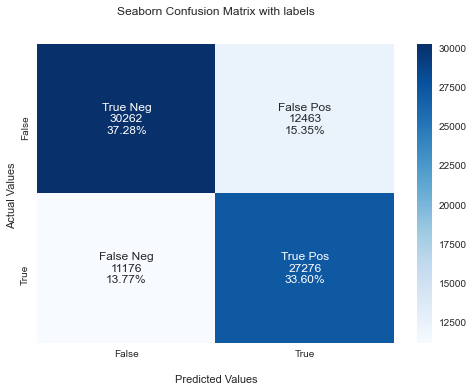

In [333]:
print('Matriz de confusión en Validación:')
plot_confusion_matrix(modelscoring.iloc[0,2])
print('Matriz de confusión en Train:')
plot_confusion_matrix(modelscoring.iloc[0,3])

El **modelo que mejor rendimiento tiene es Una regresión Logística**, con un **recall en Validación** de **0.67** y **0.70 en Train**. Hay un poco de overfitting. Esto significa que del total de clientes reales cazamos un **67 %** . Mejoramos considerablemente el modelo BaseLine.

Vamos a utilizar este algortimo para entrenar con toda la muestra, una vez hecho el ajuste de hiperparámetros y saber cuales son los hiperparámetros que mejores métricas de error ofrecen.

In [334]:
# Ahora sabemos ya cual es el emjor modelo. Hacemos optimizacion de hiperparametros. Sabemos cuales son los mejores hiperparametros
# entrenamos con toda la muestra y predecimos en test.
k = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#k = 2
baseModel = LogisticRegression(random_state=rs, class_weight = 'balanced')


random_grid = {
    'penalty' : ['l2']
}




model_tuned = RandomizedSearchCV(estimator = baseModel,
                                 param_distributions = random_grid,
                                 n_iter = 20,
                                 cv = k,
                                 verbose=0,
                                 random_state=42 ,
                                 n_jobs = -1)

model_tuned.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'penalty': ['l2']}, random_state=42)

In [335]:
predicciones = model_tuned.predict(X_val)
predicciones_train=  model_tuned.predict(X_train)

Recall en Validación: 0.6726878612716763 
Recall en Train: 0.7093519192759804
Matriz de confusión:


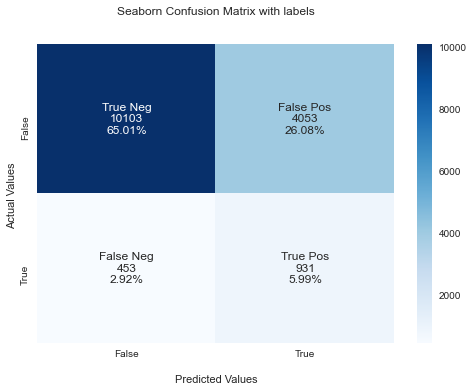

In [336]:

recall = recall_score(y_val, predicciones, average='binary') 
print(f'Recall en Validación: {recall} ')


recall_train = recall_score(y_train, predicciones_train, average='binary') 
print(f'Recall en Train: {recall_train}')


matriz_confusion = confusion_matrix(y_val, predicciones)
print('Matriz de confusión:')
plot_confusion_matrix(matriz_confusion)

**Con este modelo obtemos una métrica de error de 0.67**

**Entrenamos el modelo con toda la muestra.**

In [346]:
X = df_clasificacion[(df_clasificacion.Target == 1) | (df_clasificacion.Target == 0)].drop('Target', axis = 1)
y = df_clasificacion[(df_clasificacion.Target == 1) | (df_clasificacion.Target == 0)]['Target']
X = X.drop(['impactos_publicidad'], axis = 1)

In [347]:
# Entrenamos el modelo con toda la muestra.
X, y = sm.fit_resample(X, y)
model_tuned.fit(X, y)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'penalty': ['l2']}, random_state=42)

**Los parámetros del modelo una vez hecho RandomizedSearchCV son:**

In [348]:
model_tuned.best_params_.

{'penalty': 'l2'}

In [351]:
coef = model_tuned.best_estimator_.coef_

In [352]:
logist_regresion_coefs = pd.DataFrame([j for sub in coef for j in sub], 
             X.columns, 
             columns=['coef'])



Coeficientes de la Regresión Logística:

In [353]:
logist_regresion_coefs

,coef
habitantes_municipio,0.766685
numoficinas,0.173454
dias_creacion,-3.186552
capitalpueblo,-0.076409
enpoligono,0.272547
flotaturismos,0.082195
flotafurgonetas,0.176946
flotacamiones,-0.734768
universo,-1.025144
existe_import,0.227110


<AxesSubplot:>

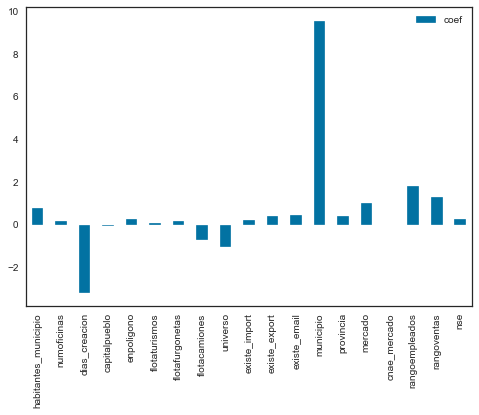

In [354]:
logist_regresion_coefs.plot(kind='bar')

Las variables con más importancia para determinar la clase postiva son **rango_empleados** y **municipio**. La que más influye para determinar la clase negativa es la **antiguedad de la empresa**. **Es decir, podemos inferir que el Target de la empresa E son empresas jovenes, con muchos empleados, y que pertenencen a una zona concreta** (dificil de determinar aquí por la conversión de categóricas multiclass a numéricas).

In [355]:
prediccion_label_test = model_tuned.predict(X_test)

In [356]:
prediccion_proba_test = model_tuned.predict_proba(X_test)[:,1]

In [357]:
# Concatenamos las prediccinoes y los ids.
df_clasficacion = X_test.copy()

In [358]:
df_clasficacion['prediccion_label_test'] = prediccion_label_test
df_clasficacion['prediccion_proba_test'] = prediccion_proba_test

In [359]:
df_clasficacion = df_clasficacion[['prediccion_label_test', 'prediccion_proba_test']]

Predecimos para el conjunto de Test, es decir, para aquellos clientes que no tienen ninguna clase asignada.

In [360]:
df_prediccion = df_clasficacion[df_clasficacion.prediccion_label_test == 1].sort_values('prediccion_proba_test', ascending=False)
df_prediccion

,prediccion_label_test,prediccion_proba_test
85857,1.0,0.999716
26458,1.0,0.999655
67974,1.0,0.999590
20672,1.0,0.999311
19193,1.0,0.999171
...,...,...
43308,1.0,0.500076
67360,1.0,0.500033
98882,1.0,0.500030
56733,1.0,0.500026


## Conclusiones

* Si utilzamos un **modelo simple**, sin realizar ningún tipo de remuestreo, ni busqueda de hiperparámetros obtenemos un resultado de **recall de 0.27**.

* Utilizando varios Algoritmos, concluimos que el que mejor se adapata a nuestro problema es una **regresión logística**. Con un **recall en Validación de 0.66**.

* Establecemos un  **umbral de 0.5** para definir a los clientes potenciales, el umbral es el punto donde mejor se separan los clientes. El umbral se puede ajustar, en función del coste que tenga captar nuevos clientes. 

* Aplicando nuestro algortimo, entrenado con toda la muestra, se encontraron **10.817 clientes potenciales**, que representan aproximadamente el **10% de la población general**.

### Ensamble de los dos modelos.

Vamos a unir las conclusiones de ambos modelos.

In [361]:
# Juntamos los dos dataet, escalamos las distancias y cogemos la minima. A partir de ahi ordenamos
df_final = pd.concat([df_cluster, df_prediccion], axis = 1)[['Distancia_minima', 'prediccion_proba_test']]
df_final

,Distancia_minima,prediccion_proba_test
0,0.769640,0.572690
1,0.702112,NaN
2,0.914607,NaN
3,0.678062,NaN
4,0.613696,NaN
...,...,...
99978,NaN,0.746471
99980,NaN,0.819404
99981,NaN,0.542720
99990,NaN,0.552284


Uniendo los potenciales clientes que dice cada modelo obtenemos **34.777 clientes potenciales**. Dónde **ambos modelos coinciden en 1.598 clientes potenciales**.

**Escalamos la distancia mínima** para que ambas columnas, la probabilidad de pertencia a la clase positiva y la distancia minima a cualquiera de los dos clusters de clientes, tengan las **mismas unidades** y se puedan comparar. Hay que tener en cuenta, que las **coclusiones van en distanta dirección**. Es decir, **a mayor es la probailidad de pertenencia a la clase positiva mejor**, y **cuanto menor es la distancia de los centroides mejor**. Para ello hacemos 1 menos la distancia mínima, y asi ambas columnas se pueden comparar,

In [362]:
scaler = MinMaxScaler()
df_final.Distancia_minima = scaler.fit_transform(df_final[['Distancia_minima']])

In [363]:
df_final.Distancia_minima  = 1 - df_final.Distancia_minima 

In [364]:
df_final['final'] = df_final.max(axis=1)

In [365]:
df_final = df_final.sort_values('final', ascending=False)
df_final

,Distancia_minima,prediccion_proba_test,final
1547,1.000000,NaN,1.000000
85857,NaN,0.999716,0.999716
26458,NaN,0.999655,0.999655
67974,NaN,0.999590,0.999590
20672,0.148182,0.999311,0.999311
...,...,...,...
22545,0.000048,NaN,0.000048
8710,0.000040,NaN,0.000040
7178,0.000033,NaN,0.000033
9693,0.000007,NaN,0.000007


**Los IDs de las empresas que son potenciales clientes, son las siguientes (ordenadas de más probabilidad a menos):**

In [366]:
list(df_final.index)

[1547,
 85857,
 26458,
 67974,
 20672,
 19193,
 57906,
 66814,
 69556,
 99544,
 14982,
 5985,
 48682,
 72936,
 31577,
 64859,
 77337,
 74842,
 42443,
 54421,
 35425,
 77156,
 62319,
 28549,
 14970,
 53073,
 60768,
 56101,
 18283,
 81779,
 7317,
 13344,
 31444,
 27957,
 44042,
 41861,
 13396,
 3775,
 75942,
 90725,
 44863,
 83167,
 24595,
 99521,
 27083,
 30631,
 3531,
 20111,
 63775,
 10398,
 96627,
 60283,
 87211,
 28131,
 40681,
 94656,
 76024,
 20217,
 88080,
 79634,
 35490,
 93133,
 45516,
 93936,
 40793,
 3143,
 20891,
 37654,
 12060,
 12967,
 59706,
 74927,
 37960,
 16283,
 34762,
 38300,
 65787,
 55094,
 24085,
 51959,
 77230,
 41067,
 88065,
 52944,
 92780,
 13535,
 35087,
 63784,
 80467,
 44837,
 39831,
 846,
 51412,
 89769,
 32693,
 57471,
 80175,
 22303,
 87450,
 87442,
 18617,
 31926,
 27215,
 9061,
 20519,
 29060,
 1334,
 99001,
 66641,
 9274,
 50452,
 86086,
 51642,
 98603,
 35913,
 80305,
 3762,
 70738,
 49549,
 24153,
 82018,
 54215,
 67284,
 60841,
 74042,
 26166,
 907

In [370]:
!jupyter nbconvert --no-input --to html Prueba.ipynb

[NbConvertApp] Converting notebook Prueba.ipynb to html
[NbConvertApp] Writing 4647571 bytes to Prueba.html
